In [1]:
# Capstone Project - Walmart
# Gaurav Singh - grv08singh@gmail.com

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr
wr.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX,SARIMAXResults

In [3]:
df = pd.read_csv("Walmart DataSet.csv")

In [4]:
df.sample(3)

Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
3106     22  27-01-2012     786459.23             0        35.68       3.568   
5533     39  30-12-2011    1537139.56             1        47.60       3.129   
5903     42  12-11-2010     588592.61             0        61.24       3.130   

             CPI  Unemployment  
3106  140.912402         7.503  
5533  218.230236         7.716  
5903  126.546161         9.003

## 1) Data Inspection and Cleaning

In [5]:
df.shape

(6435, 8)

#### There are 6435 rows in raw data with 8 features

In [6]:
df.columns.to_list()

['Store',
 'Date',
 'Weekly_Sales',
 'Holiday_Flag',
 'Temperature',
 'Fuel_Price',
 'CPI',
 'Unemployment']

#### This is the list of feature names

In [7]:
df.duplicated().sum()

np.int64(0)

#### There are no duplicate rows

In [8]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

#### There are no null values in the raw dataset

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


#### Out of 8, one feature is `Object` datatype, two are `Integer` & five are `Float`.
#### Date is in `object` datatype that too in `dd-mm-YYYY` format.
#### We need to change the data type of `Date` feature from `object` to standard `YYYY-mm-dd` `Datetime` format

In [10]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

#### Now, the `Date` feature in standard `Datetime` format

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


#### 1. You are provided with the weekly sales data for their various outlets.
#### Use statistical analysis, 

In [12]:
#Statistical Summary
df.describe(exclude='datetime64').T

count          mean            std         min         25%  \
Store         6435.0  2.300000e+01      12.988182       1.000      12.000   
Weekly_Sales  6435.0  1.046965e+06  564366.622054  209986.250  553350.105   
Holiday_Flag  6435.0  6.993007e-02       0.255049       0.000       0.000   
Temperature   6435.0  6.066378e+01      18.444933      -2.060      47.460   
Fuel_Price    6435.0  3.358607e+00       0.459020       2.472       2.933   
CPI           6435.0  1.715784e+02      39.356712     126.064     131.735   
Unemployment  6435.0  7.999151e+00       1.875885       3.879       6.891   

                        50%           75%           max  
Store             23.000000  3.400000e+01  4.500000e+01  
Weekly_Sales  960746.040000  1.420159e+06  3.818686e+06  
Holiday_Flag       0.000000  0.000000e+00  1.000000e+00  
Temperature       62.670000  7.494000e+01  1.001400e+02  
Fuel_Price         3.445000  3.735000e+00  4.468000e+00  
CPI              182.616521  2.127433e+02  2.272328e+02  
Unemployment       7.874000  8.622000e+00  1.431300e+01

In [13]:
num_features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
cat_features = ['Store','Holiday_Flag']

In [14]:
#Categorical columns unique values
for col in cat_features:
    print(f"Number of unique values in `{col}`: {df[col].nunique()}")
    print(f"Unique values in `{col}` are: {df[col].unique().tolist()}\n")
        

Number of unique values in `Store`: 45
Unique values in `Store` are: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]

Number of unique values in `Holiday_Flag`: 2
Unique values in `Holiday_Flag` are: [0, 1]



#### EDA, 

In [15]:
#### EDA
## Univariate Analysis: 
# Mean, Median, Mode, 
# Range, Std, IQR, 
# Countplot, Histograms, Pie Charts, Frequency Polygons

#### Univariate Analysis - Mean, Median, Mode, Range, Standard Deviation, IQR

In [16]:
for col in num_features:
    print(f"{col}:")
    print(f"Mean: {df[col].mean()}")
    print(f"Median: {df[col].median()}")
    print(f"Mode: {df[col].mode()[0]}")
    print(f"Range: {df[col].max() - df[col].min()} = {df[col].min()} to {df[col].max()}")
    print(f"Std: {df[col].std()}")
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    print(f"Range: {Q3 - Q1} = {Q1} to {Q3} \n\n")

Weekly_Sales:
Mean: 1046964.8775617715
Median: 960746.04
Mode: 209986.25
Range: 3608700.2 = 209986.25 to 3818686.45
Std: 564366.6220536974
Range: 866808.5549999999 = 553350.105 to 1420158.66 


Temperature:
Mean: 60.66378243978244
Median: 62.67
Mode: 50.43
Range: 102.2 = -2.06 to 100.14
Std: 18.444932875811585
Range: 27.479999999999997 = 47.46 to 74.94 


Fuel_Price:
Mean: 3.358606837606838
Median: 3.445
Mode: 3.638
Range: 1.996 = 2.472 to 4.468
Std: 0.4590197071928516
Range: 0.802 = 2.933 to 3.735 


CPI:
Mean: 171.57839384878014
Median: 182.6165205
Mode: 126.064
Range: 101.1688068 = 126.064 to 227.2328068
Std: 39.35671229566413
Range: 81.00829345 = 131.735 to 212.74329345 


Unemployment:
Mean: 7.99915104895105
Median: 7.874
Mode: 8.099
Range: 10.434000000000001 = 3.879 to 14.313
Std: 1.8758847818628084
Range: 1.7309999999999999 = 6.891 to 8.622 




#### Univariate Analysis - Countplot of Holidays and Normal Days

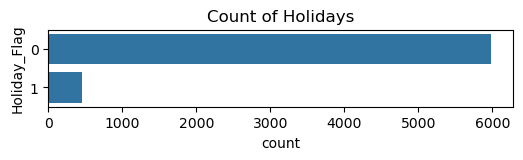

In [17]:
plt.figure(figsize=(6,1))
sns.countplot(data=df, y='Holiday_Flag')
plt.title("Count of Holidays")
plt.show()

#### Univariate Analysis - Histogram and KDE plot of all the numeric features

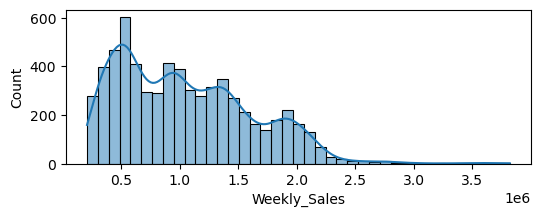

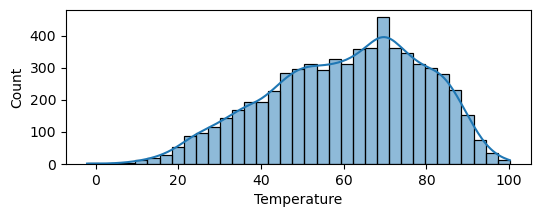

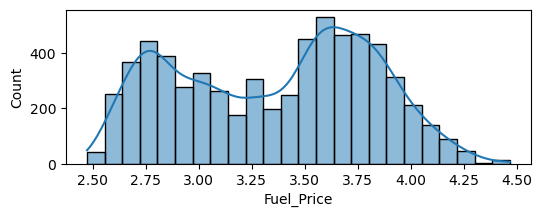

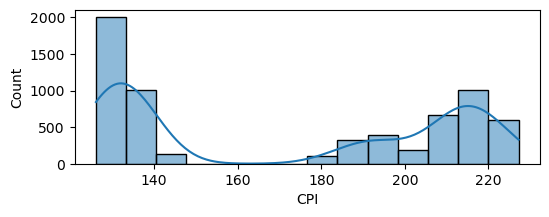

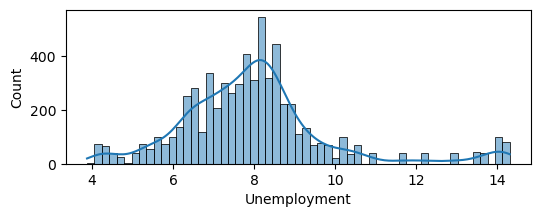

In [18]:
for col in num_features:
    plt.figure(figsize=(6,2))
    sns.histplot(data=df, x=col, kde=True)
    
    plt.show()

#### Univariate Analysis - Pie Chart

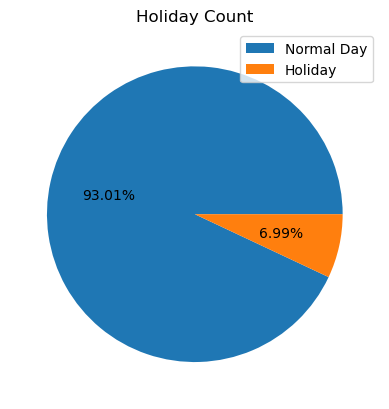

In [19]:
plt.pie(df['Holiday_Flag'].value_counts(), autopct='%1.2f%%')
plt.legend(['Normal Day','Holiday'])
plt.title("Holiday Count")
plt.show()

In [20]:
#### EDA
## Bivariate Analysis: Pair Plot, Scatter Plot

#### Bivariate Analysis - Pair Plot

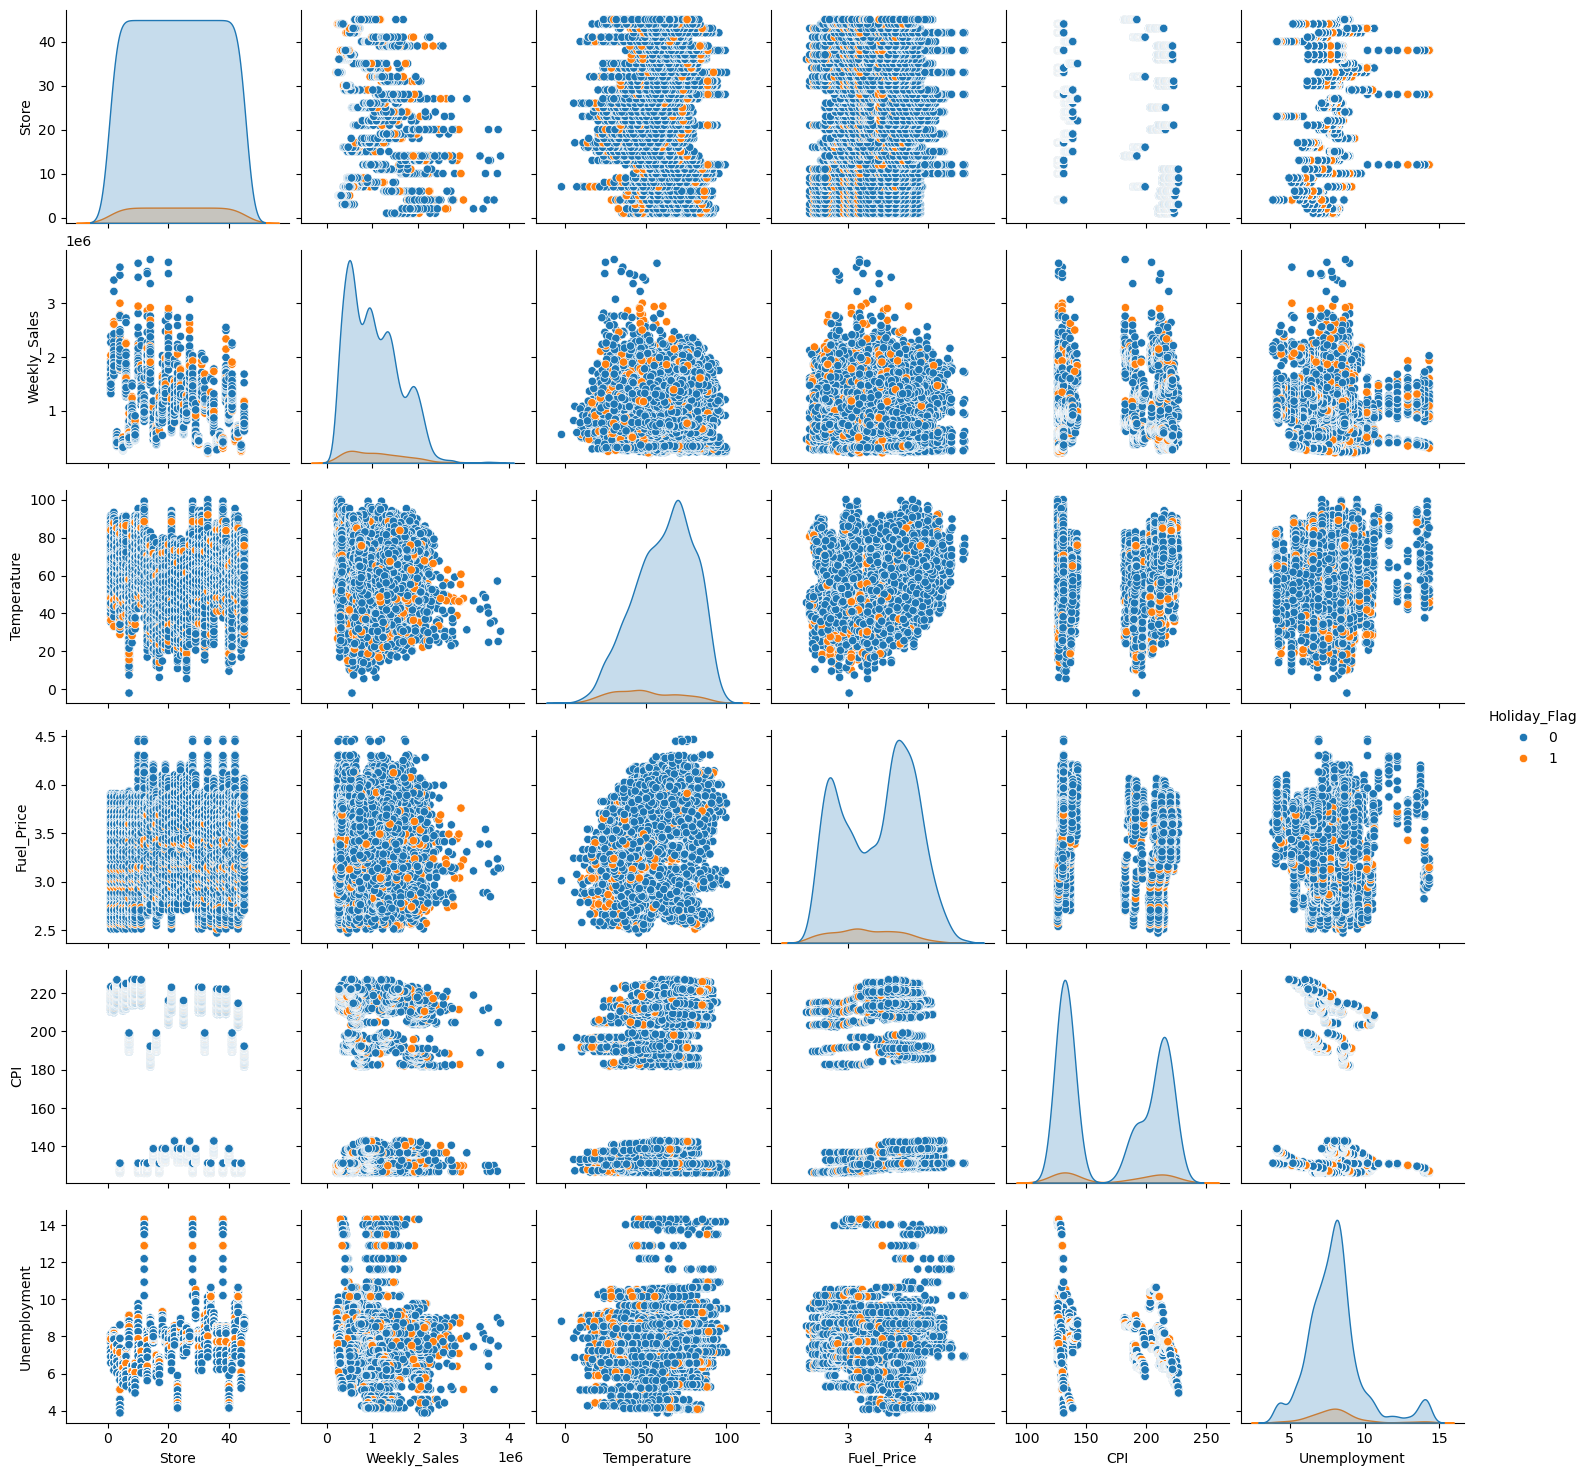

In [21]:
sns.pairplot(df, hue='Holiday_Flag')
plt.show()

#### Bivariate Analysis - Scatter Plot

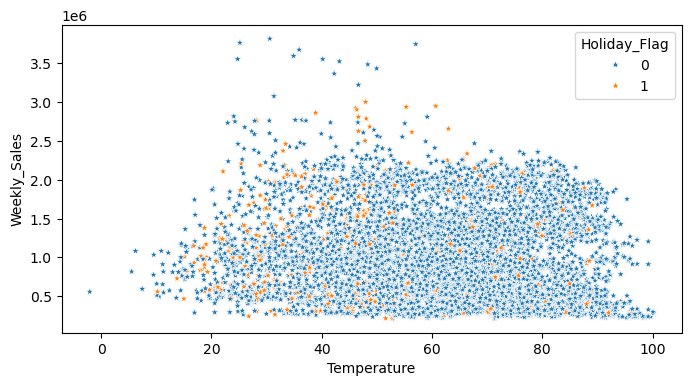

In [22]:
plt.figure(figsize=(8,4))
sns.scatterplot(data=df, x='Temperature', y='Weekly_Sales', marker='*', hue='Holiday_Flag')
plt.show()

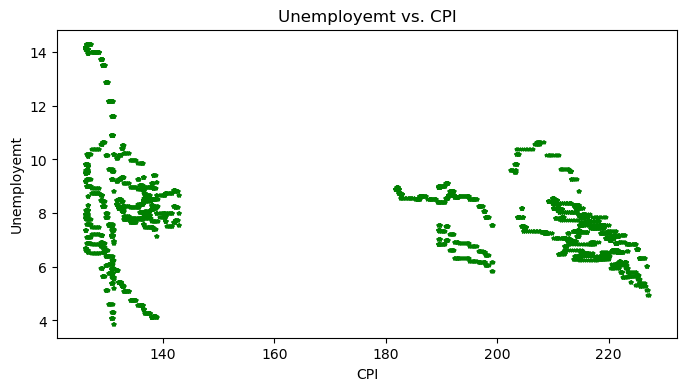

In [23]:
plt.figure(figsize=(8,4))
plt.scatter(x=df['CPI'], y=df['Unemployment'], marker='*', s=5, c='green')
plt.xlabel('CPI')
plt.ylabel('Unemployemt')
plt.title('Unemployemt vs. CPI')
plt.show()

In [24]:
#### EDA
## Multivariate Analysis

#### Multivariate Analysis - heatmap

In [25]:
df1 = df.drop(columns=['Date', 'Holiday_Flag'])
df1.corr()

Store  Weekly_Sales  Temperature  Fuel_Price       CPI  \
Store         1.000000     -0.335332    -0.022659    0.060023 -0.209492   
Weekly_Sales -0.335332      1.000000    -0.063810    0.009464 -0.072634   
Temperature  -0.022659     -0.063810     1.000000    0.144982  0.176888   
Fuel_Price    0.060023      0.009464     0.144982    1.000000 -0.170642   
CPI          -0.209492     -0.072634     0.176888   -0.170642  1.000000   
Unemployment  0.223531     -0.106176     0.101158   -0.034684 -0.302020   

              Unemployment  
Store             0.223531  
Weekly_Sales     -0.106176  
Temperature       0.101158  
Fuel_Price       -0.034684  
CPI              -0.302020  
Unemployment      1.000000

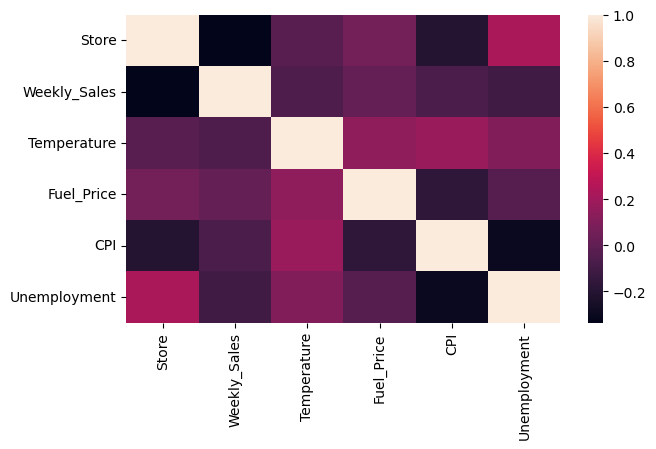

In [26]:
plt.figure(figsize = (7,4))
sns.heatmap(data=df1.corr())
plt.show()

#### outlier analysis, and

In [27]:
df.columns.tolist()

['Store',
 'Date',
 'Weekly_Sales',
 'Holiday_Flag',
 'Temperature',
 'Fuel_Price',
 'CPI',
 'Unemployment']

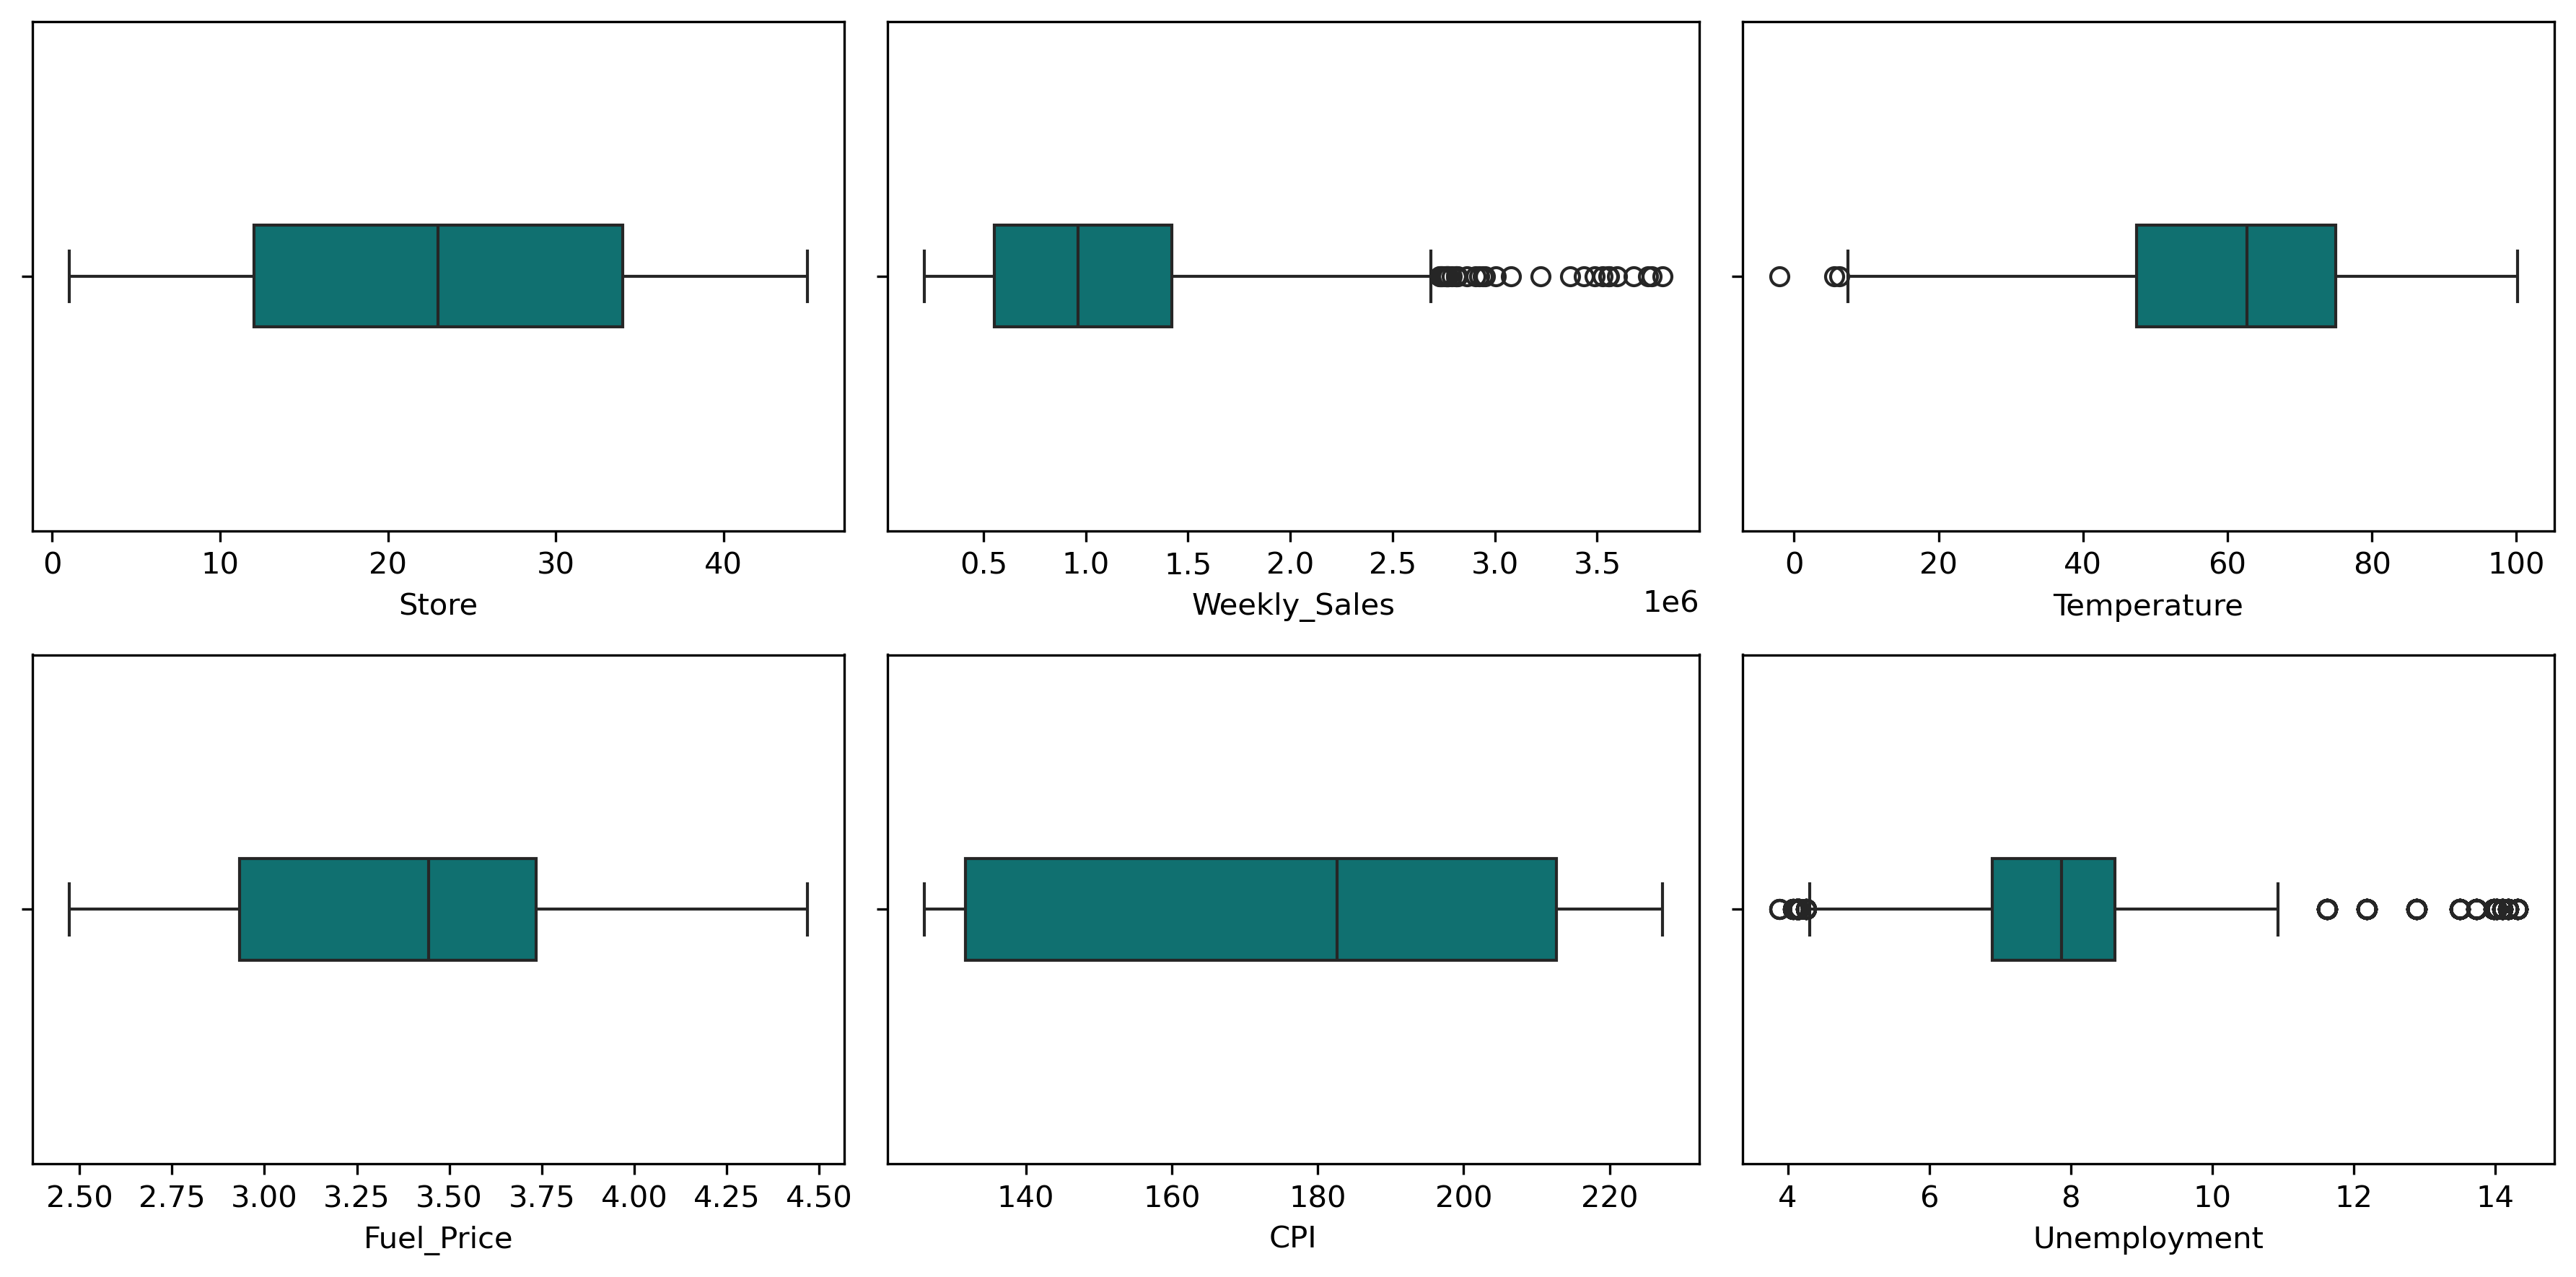

In [28]:
# Outlier Analysis
cols = ['Store', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
fig = plt.figure(figsize=(12,6),dpi=300)
i = 1
for col in cols:
    if df[col].dtype != 'object':
        plt.subplot(2, 3, i)
        sns.boxplot(data=df, x=col, width=0.2, color='teal')
        plt.tight_layout()
        # or
        # plt.boxplot(x=df[col])
        # plt.title(col)
        i += 1
plt.show()

#### It can be seen that outliers are present in `Weekly_Sales`, `Temperature` & `Unemployment`

In [29]:
#Removing Outliers:
initial_size = df.shape[0]
for col in ['Weekly_Sales', 'Temperature', 'Unemployment']:
    if(df[col].dtype in ('int64', 'float64')):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3-Q1
        LB = Q1 - 1.5 * (IQR)
        UB = Q3 + 1.5 * (IQR)
        df1 = df[ (df[col] >= LB) & (df[col] <= UB) ]
final_size = df1.shape[0]
print(f"rows removed: {initial_size - final_size}")

rows removed: 481


#### in removing the existing outliers, 481 rows were removed from the dataset

#### handle the missing values to 
#### come up with various insights that can give them a clear perspective on the following:
#### a) If the weekly sales are affected by the unemployment rate, if yes - which stores
#### are suffering the most?

In [30]:
#finding the correlation of weekly_sales with unemployement_rate for each store
import statistics as st
df2 = df1[['Store','Weekly_Sales','Unemployment']]
corr_coef = []
for store in df2['Store'].unique():
    df3 = df2[df2['Store']==store]
    corr_coef.append(st.correlation(df3['Weekly_Sales'], df3['Unemployment']))
pd.Series(corr_coef).sort_values(ascending=True)

43   -0.780076
38   -0.384681
41   -0.356355
3    -0.354789
40   -0.350630
16   -0.263600
2    -0.230413
36   -0.221287
39   -0.213724
4    -0.207043
42   -0.201954
8    -0.191534
22   -0.178507
12   -0.171633
6    -0.165382
31   -0.099455
0    -0.097955
19   -0.095341
15   -0.070864
37   -0.069747
25   -0.066899
27   -0.066340
30   -0.064738
7    -0.052580
10   -0.020339
26   -0.014275
23   -0.012261
24   -0.004958
44   -0.004041
11    0.015141
33    0.017010
21    0.039043
5     0.044251
1     0.066325
14    0.078905
28    0.084682
32    0.101175
18    0.101464
9     0.131908
17    0.139179
29    0.201862
13    0.210786
20    0.218367
34    0.483865
35    0.833734
dtype: float64

#### Store number 43 is highly impacted (negatively) by the change in Unemployment Rate.

In [31]:
df4 = pd.DataFrame(df1.groupby('Date')['Weekly_Sales'].sum())
df4.reset_index(inplace=True)
df4.sort_values('Date')
df4

Date  Weekly_Sales
0   2010-02-05   46619845.70
1   2010-02-12   45317630.91
2   2010-02-19   45363033.79
3   2010-02-26   41043557.90
4   2010-03-05   43813776.69
..         ...           ...
138 2012-09-28   39468648.67
139 2012-10-05   42823075.29
140 2012-10-12   41600039.67
141 2012-10-19   40743817.45
142 2012-10-26   41125802.72

[143 rows x 2 columns]

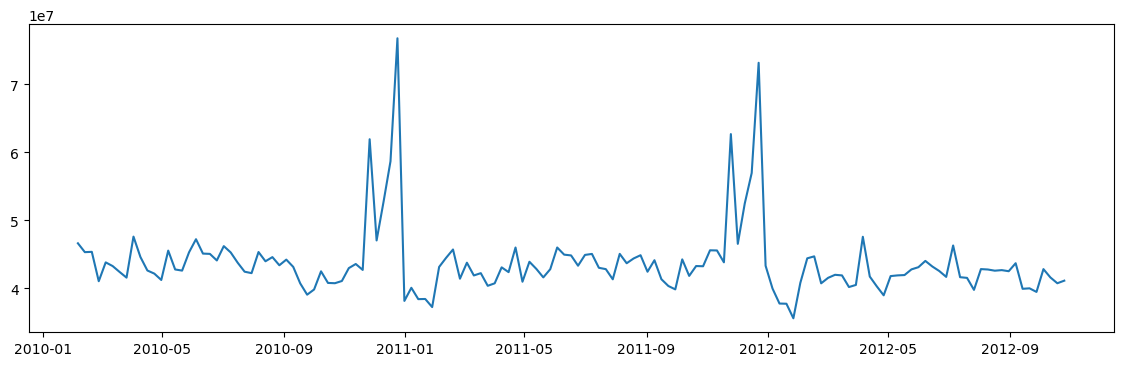

In [32]:
# b. If the weekly sales show a seasonal trend, when and what could be the reason?

plt.figure(figsize=(14,4))
plt.plot(df4['Date'], df4['Weekly_Sales'])
plt.show()

#### Sales show a seasonal trend, hit yearly high during the last month of every year because of the Christmas and the New Year

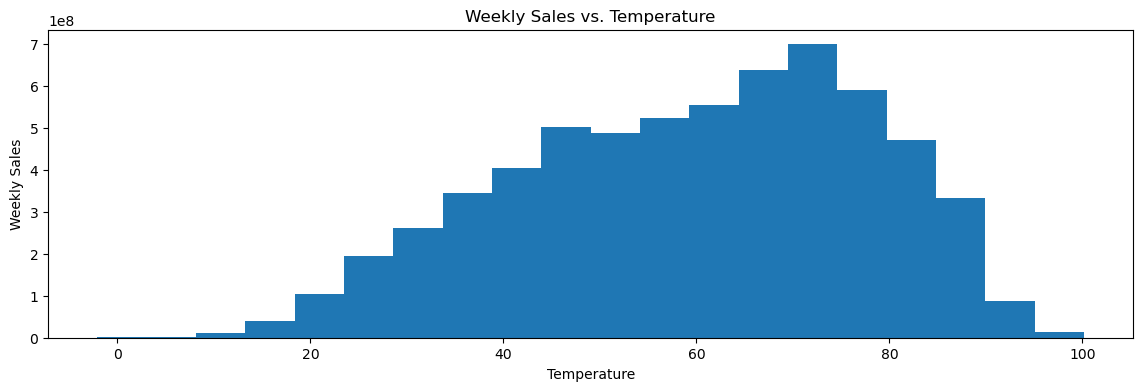

In [33]:
# c. Does temperature affect the weekly sales in any manner?

plt.figure(figsize=(14,4))
#sns.histplot(data=df1, x='Temperature', kde=True)
plt.hist(x=df1['Temperature'],bins=20,weights=df1['Weekly_Sales'],density=False)
plt.xlabel("Temperature")
plt.ylabel("Weekly Sales")
plt.title("Weekly Sales vs. Temperature")
plt.show()

#### temperature affects the weekly sales: Weekly sales are high when the temperature is pleasant, and weekly sales are low when temperature is cold or hot.

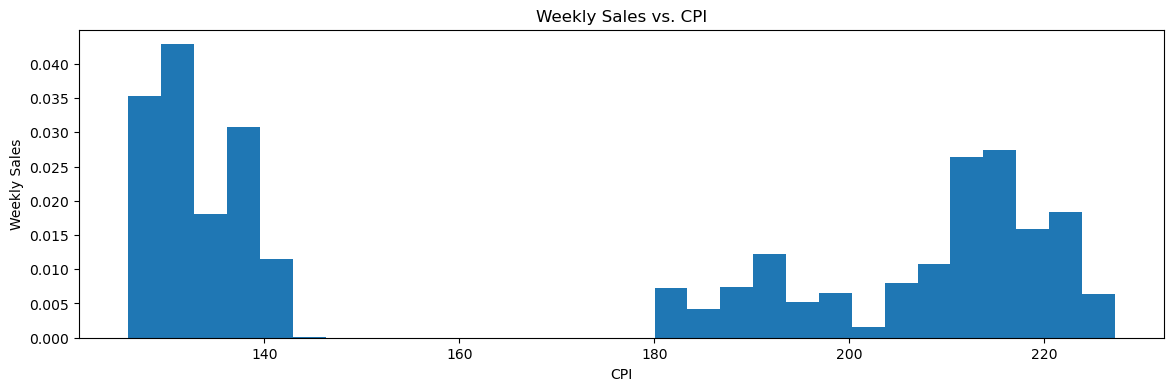

In [34]:
# d. How is the Consumer Price index affecting the weekly sales of various stores?

plt.figure(figsize=(14,4))
plt.hist(x=df1['CPI'],bins=30,weights=df1['Weekly_Sales'],density=True)
plt.xlabel("CPI")
plt.ylabel("Weekly Sales")
plt.title("Weekly Sales vs. CPI")
plt.show()

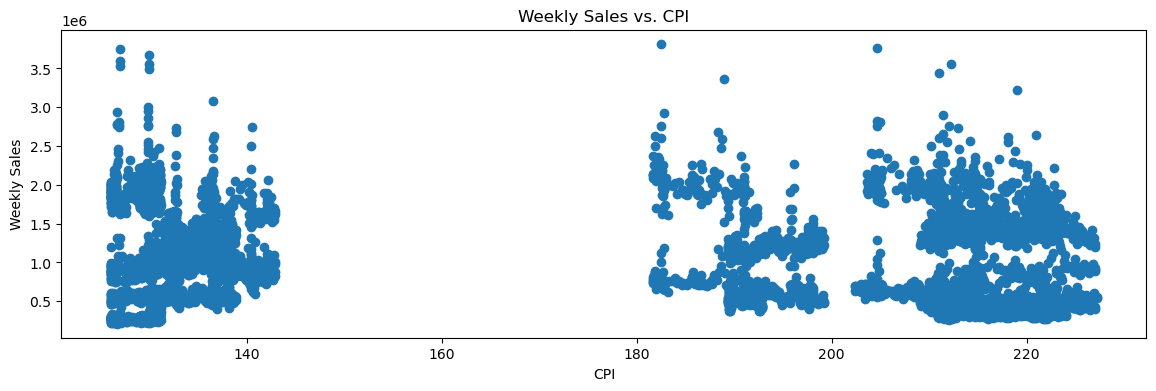

In [35]:
plt.figure(figsize=(14,4))
plt.scatter(df1['CPI'],df1['Weekly_Sales'])
plt.xlabel("CPI")
plt.ylabel("Weekly Sales")
plt.title("Weekly Sales vs. CPI")
plt.show()

#### There are no weekly sales when CPI is between 145 and 180

In [36]:
df1.head(2)

Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2010-02-05    1643690.90             0        42.31       2.572   
1      1 2010-02-12    1641957.44             1        38.51       2.548   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106

In [37]:
# e. Top performing stores according to the historical data.
pd.options.display.float_format = '{:,.0f}'.format

df5 = df1.groupby('Store')['Weekly_Sales'].sum().reset_index()
df5 = df5.sort_values(by='Weekly_Sales',ascending=False).head()
df5

Store  Weekly_Sales
19     20   301,397,792
13     14   288,999,911
12     13   286,517,704
1       2   275,382,441
9      10   271,617,714

#### above are the 5 top performing stores along with their sales


In [38]:
# f. The worst performing store, and how significant is the difference between the
# highest and lowest performing stores.

df6 = df1.groupby('Store')['Weekly_Sales'].sum().reset_index()
df6 = df6.sort_values(by='Weekly_Sales',ascending=True).head()
df6

Store  Weekly_Sales
37     38     7,347,379
11     12    16,386,711
27     28    21,106,768
32     33    37,160,222
43     44    43,293,088

#### above are the 5 worst performing stores along with their sales


#### it can be seen that the top performing stores have their sales in 9 digits, however, the worst performing stores have their sales in 7 or 8 digits only. 
#### It means that the top performing stores have 10 to 100 times more sales than worst performing stores


In [39]:
# 2. Use predictive modeling techniques to forecast the sales for 
# each store for the next 12 weeks.

In [40]:
df6 = df1[['Store','Date','Weekly_Sales']]
df6.set_index('Date',inplace=True)
df.sort_index(inplace=True)

In [41]:
def stationary(df):
    #adfuller hypothesis test to check the stationarity
    #H0: Non Stationary                #Ha: Stationary
    p_val = adfuller(df)[1]
    if p_val < 0.05:
        return True
    else:
        return False

#### since the data is `stationary` for all stores, no need to do `box-cox` or `differencing` transformation

Store: 1


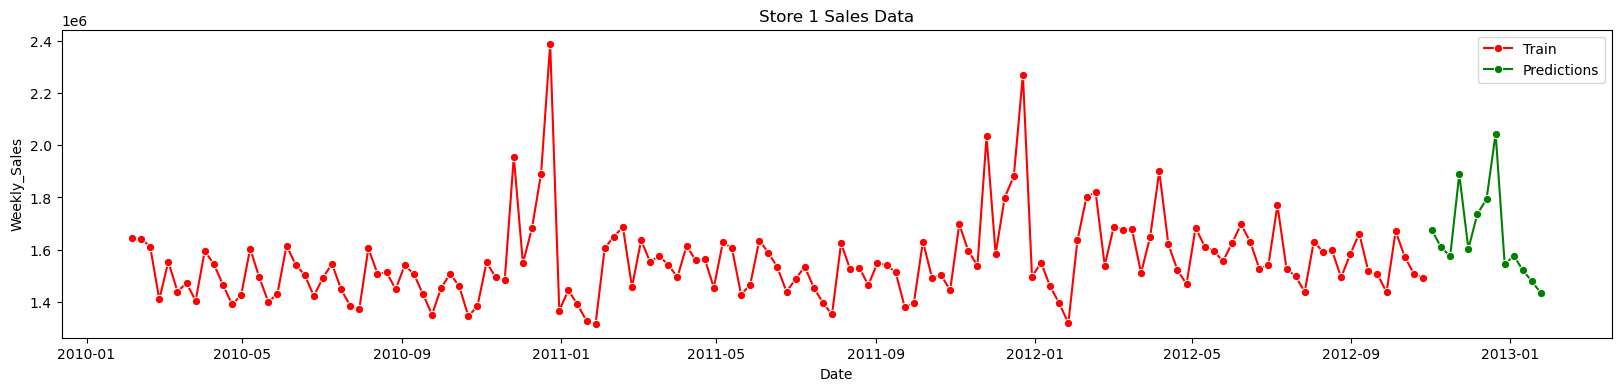

Store: 2


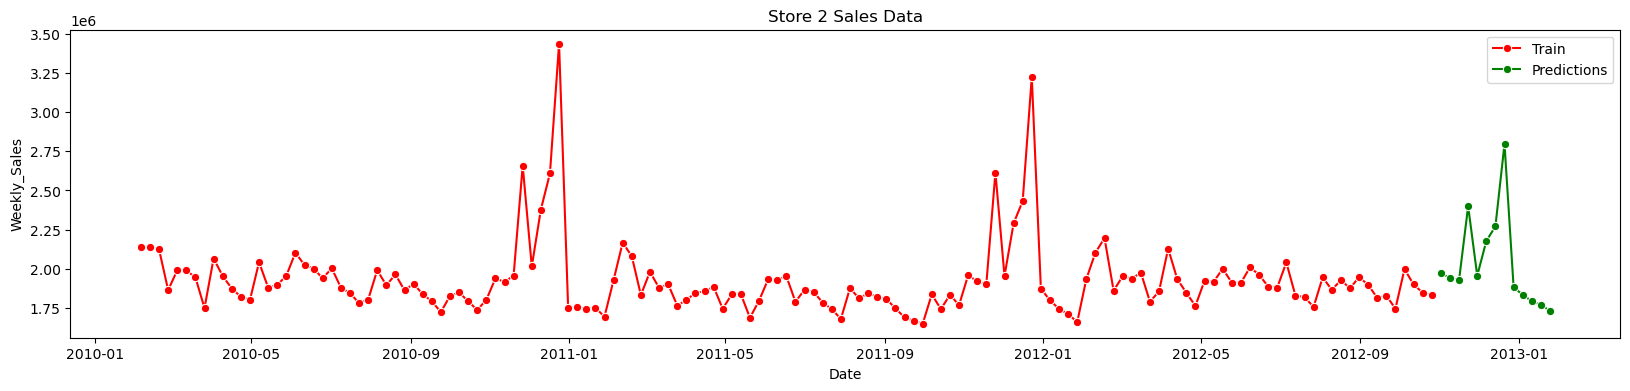

Store: 3


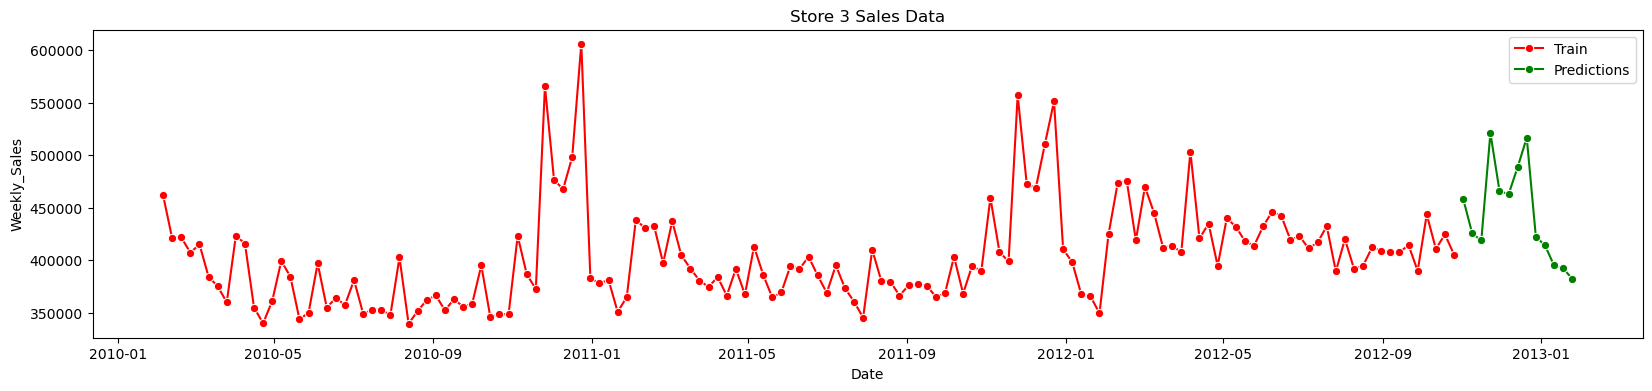

Store: 4


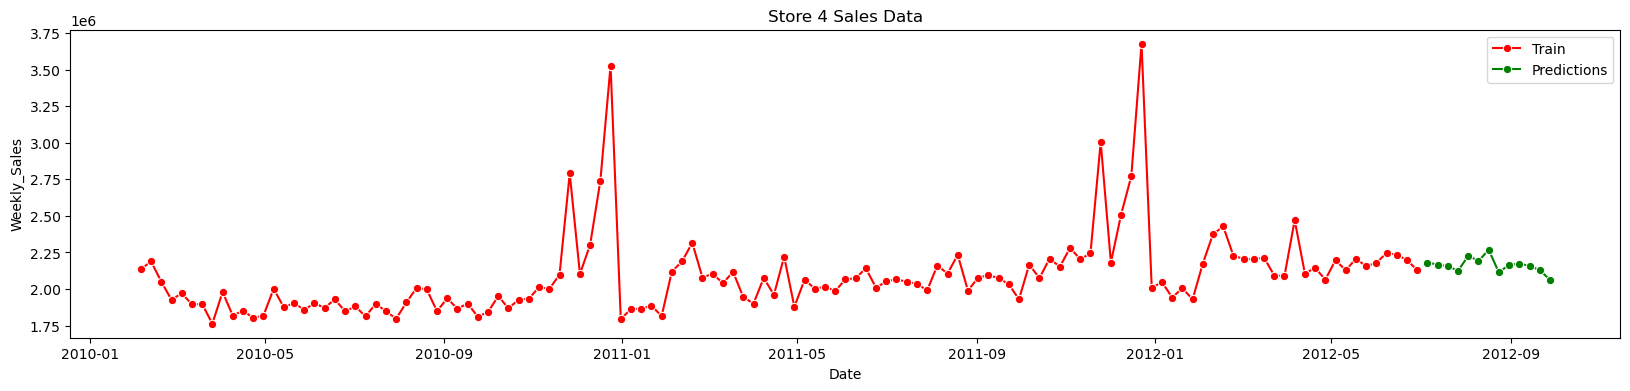

Store: 5


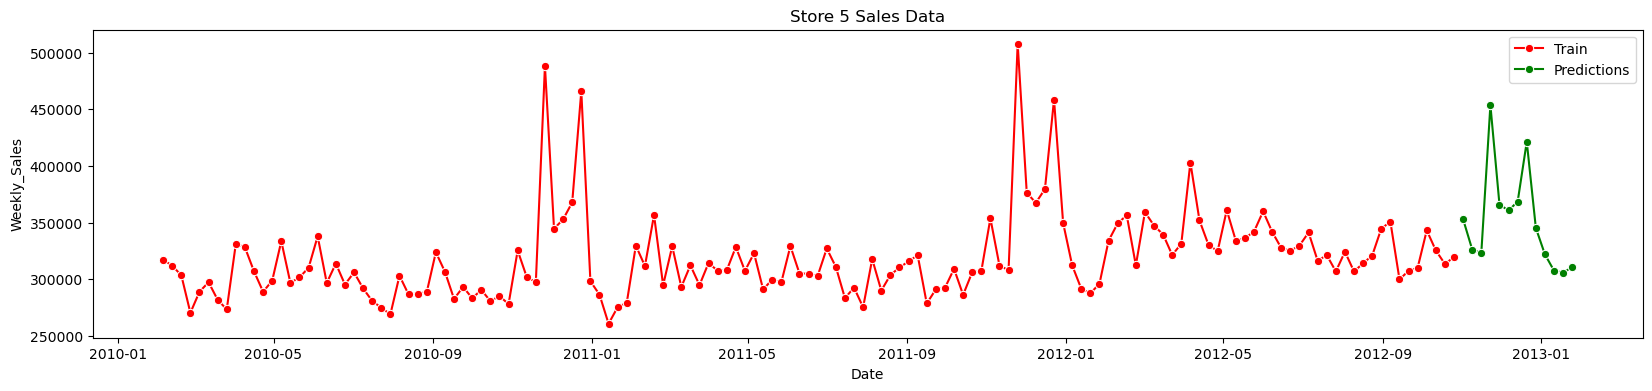

Store: 6


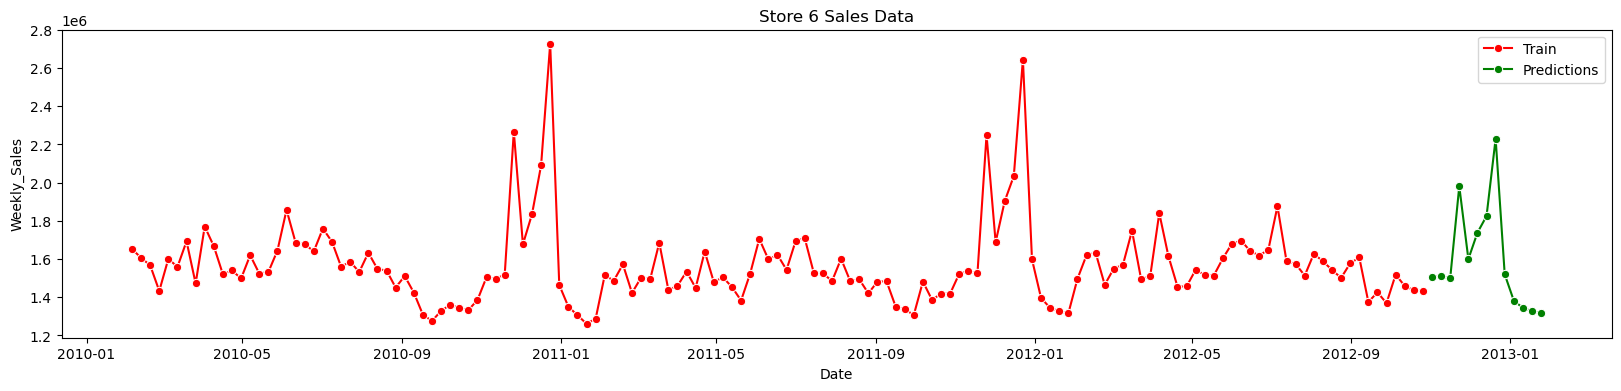

Store: 7


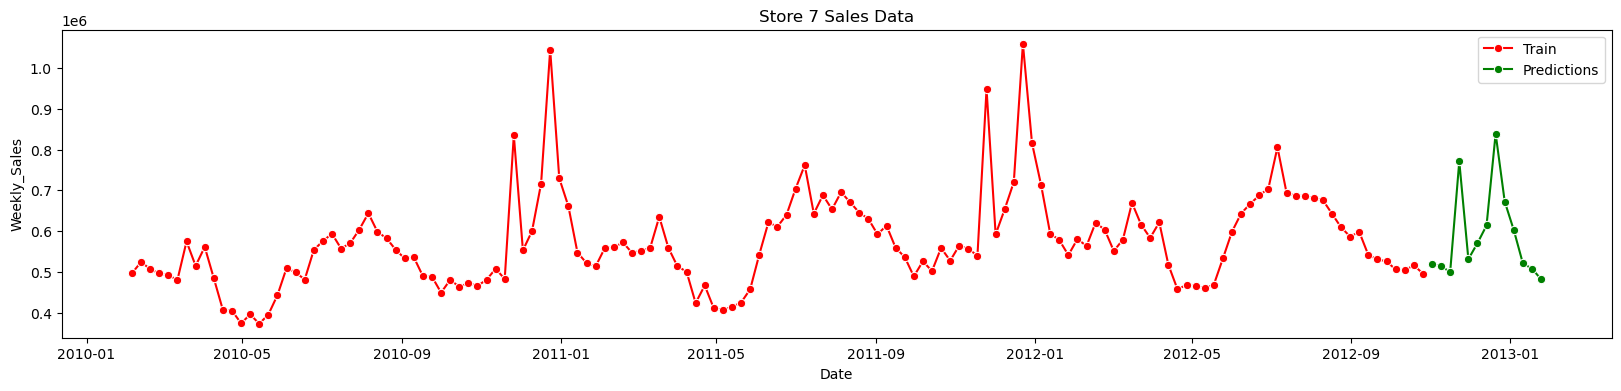

Store: 8


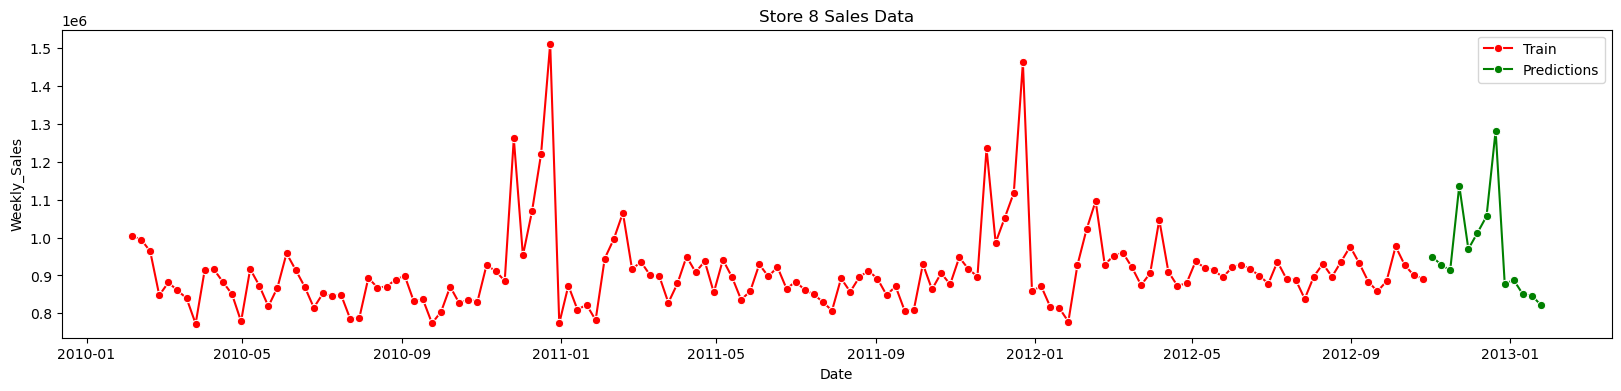

Store: 9


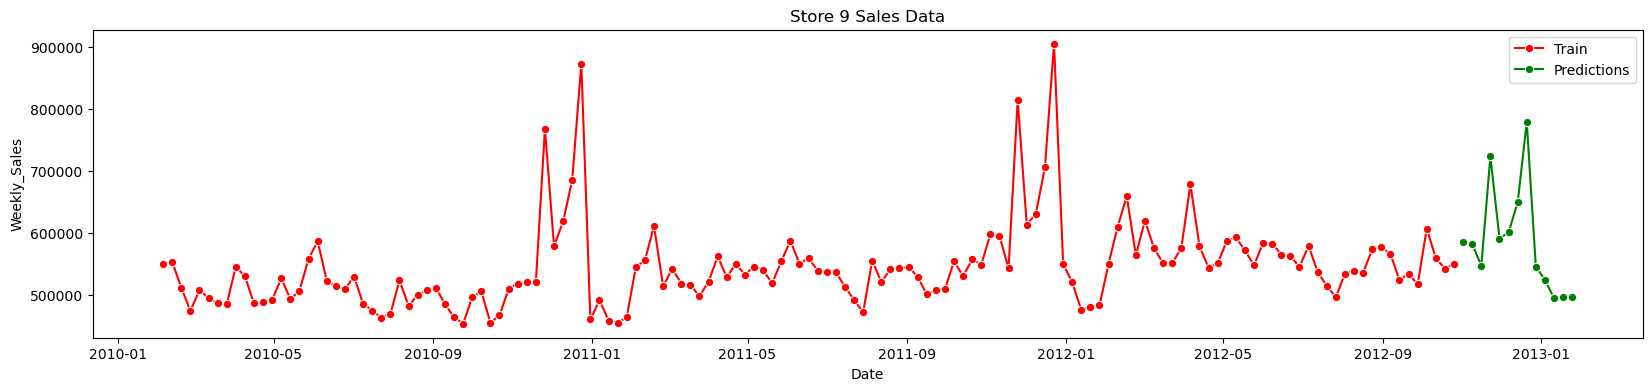

Store: 10


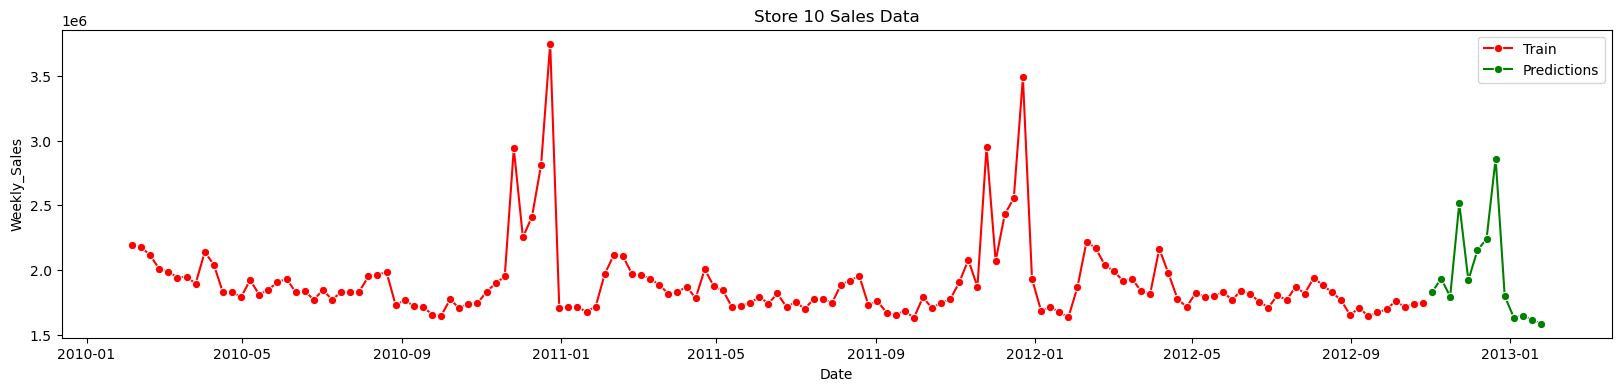

Store: 11


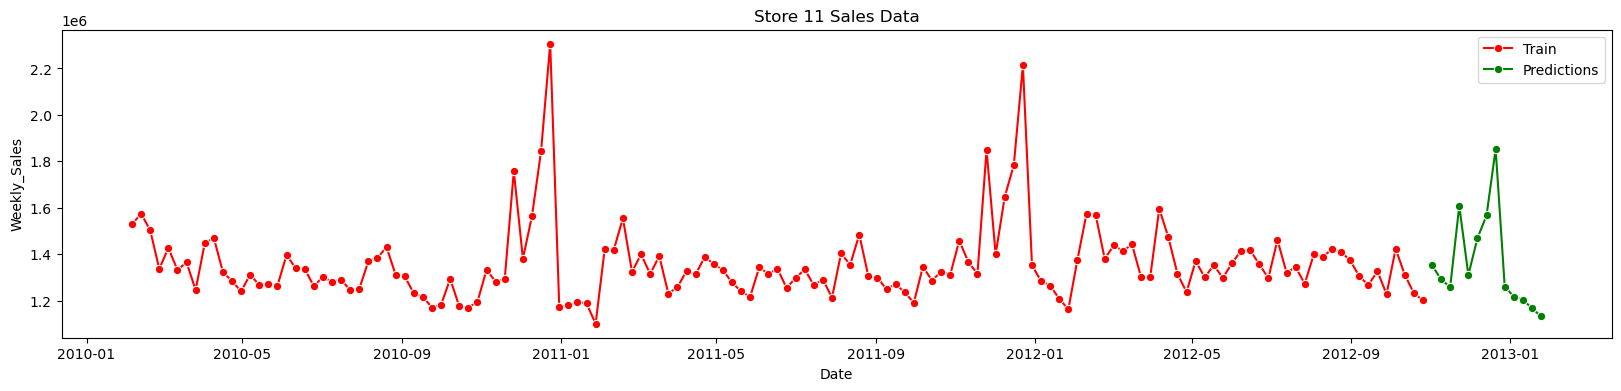

Store: 12


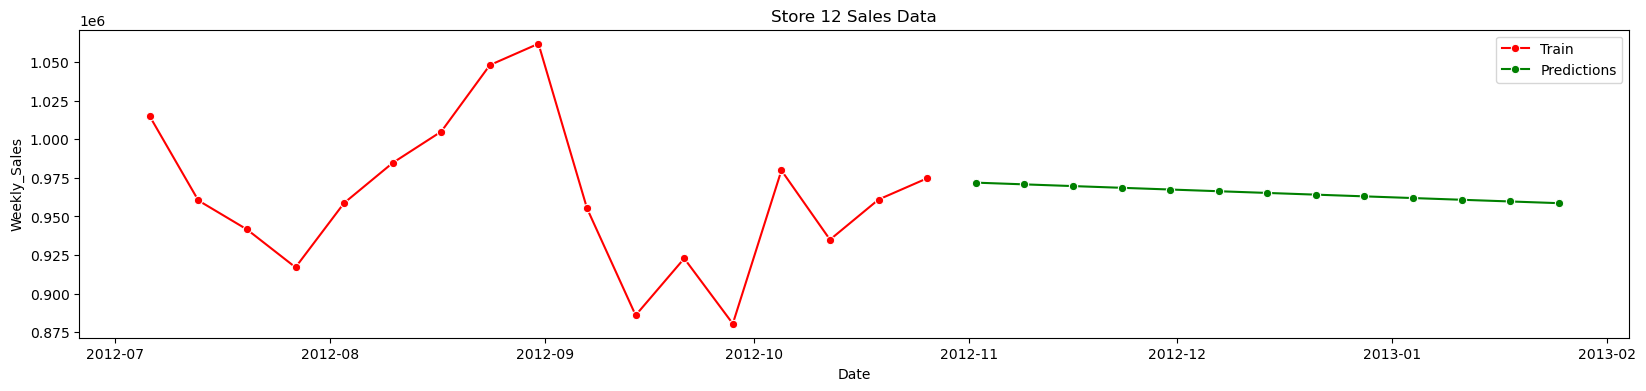

Store: 13


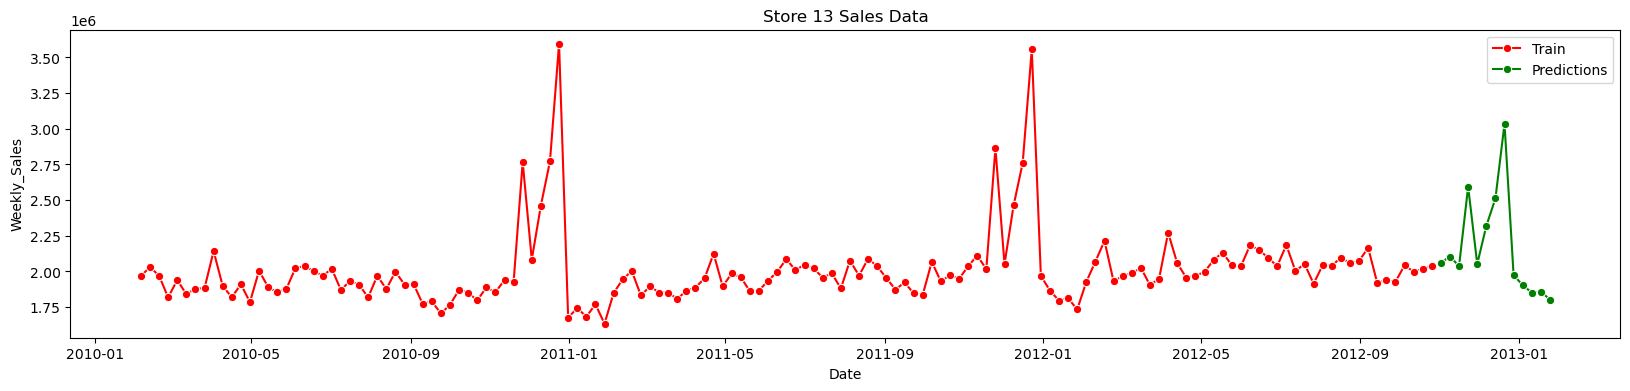

Store: 14


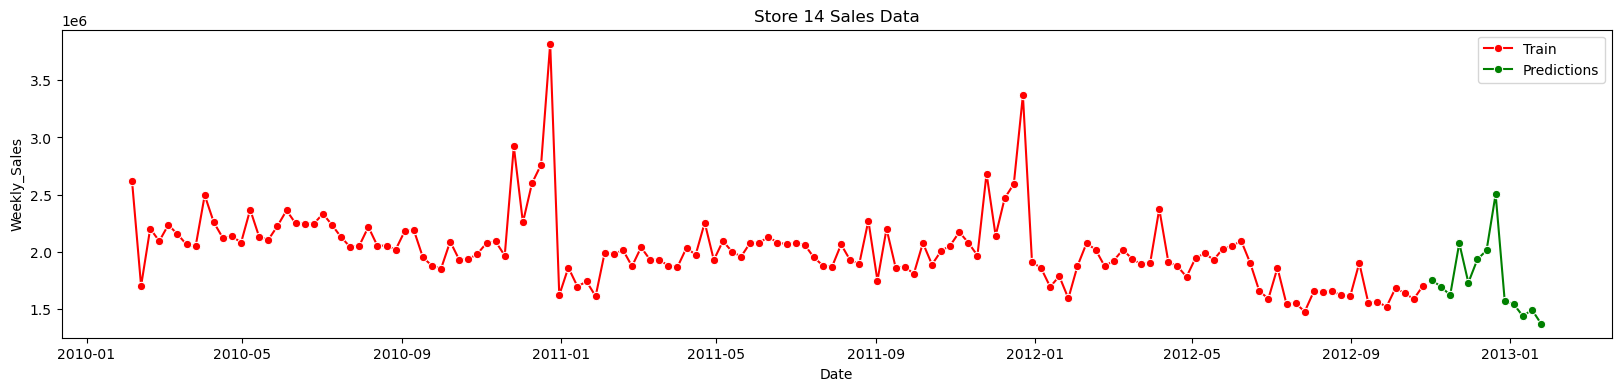

Store: 15


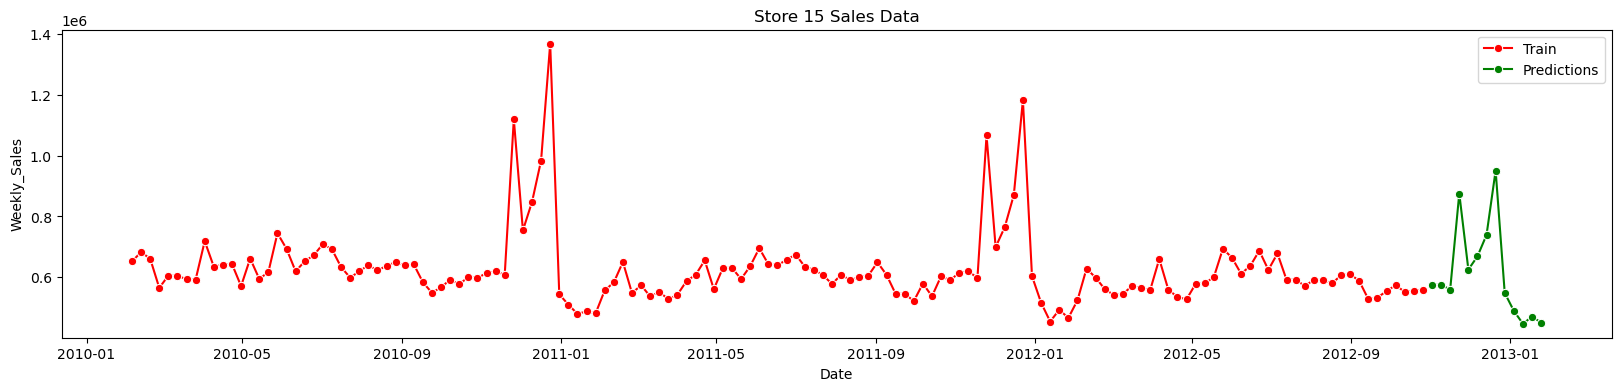

Store: 16


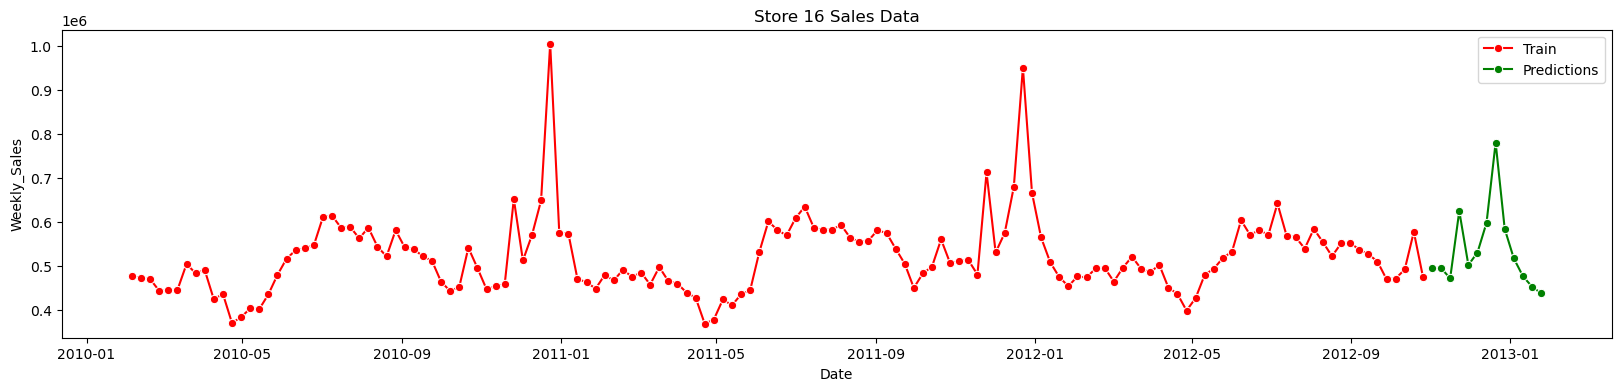

Store: 17


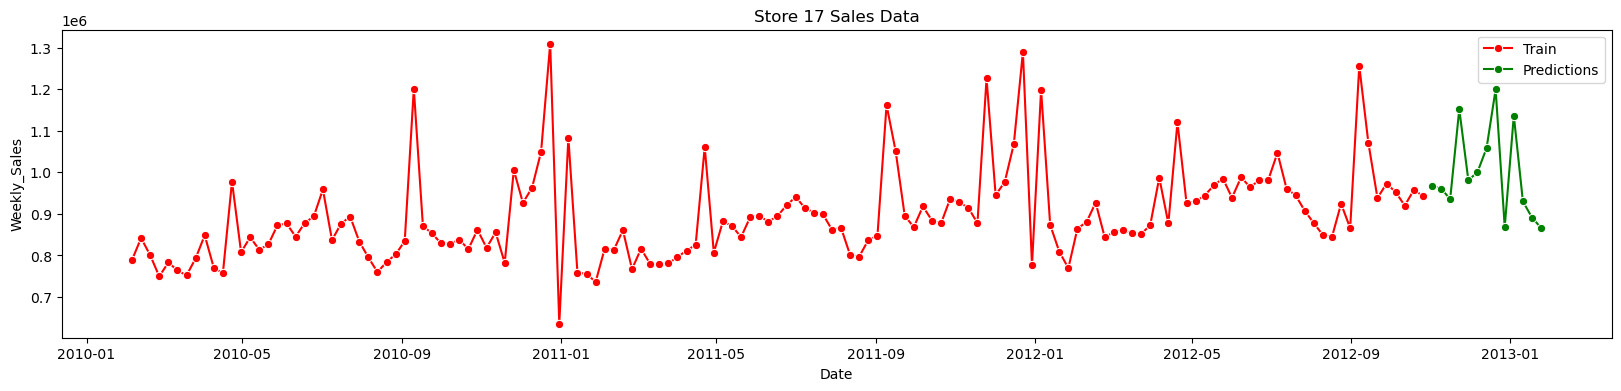

Store: 18


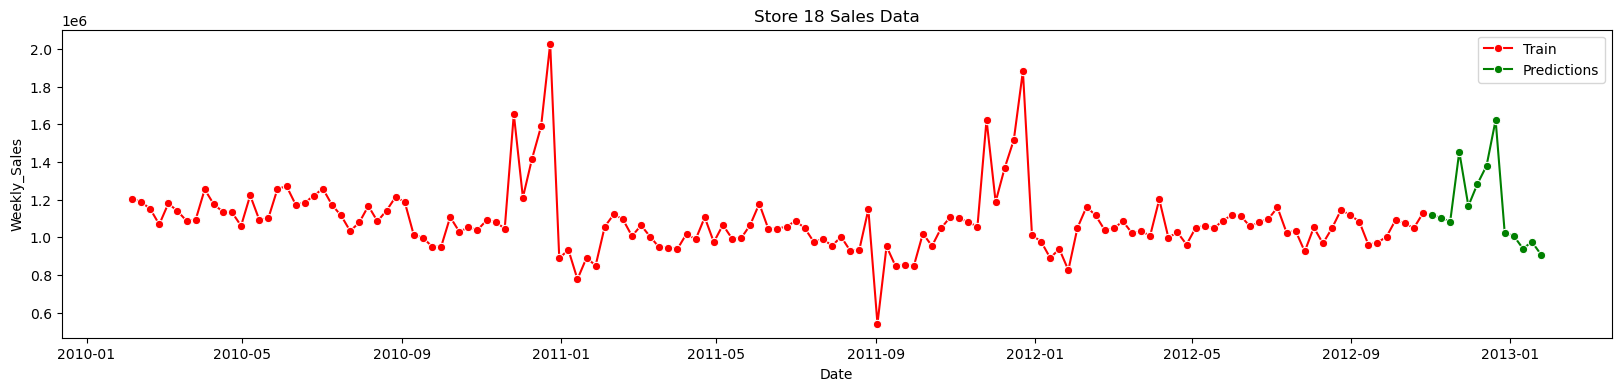

Store: 19


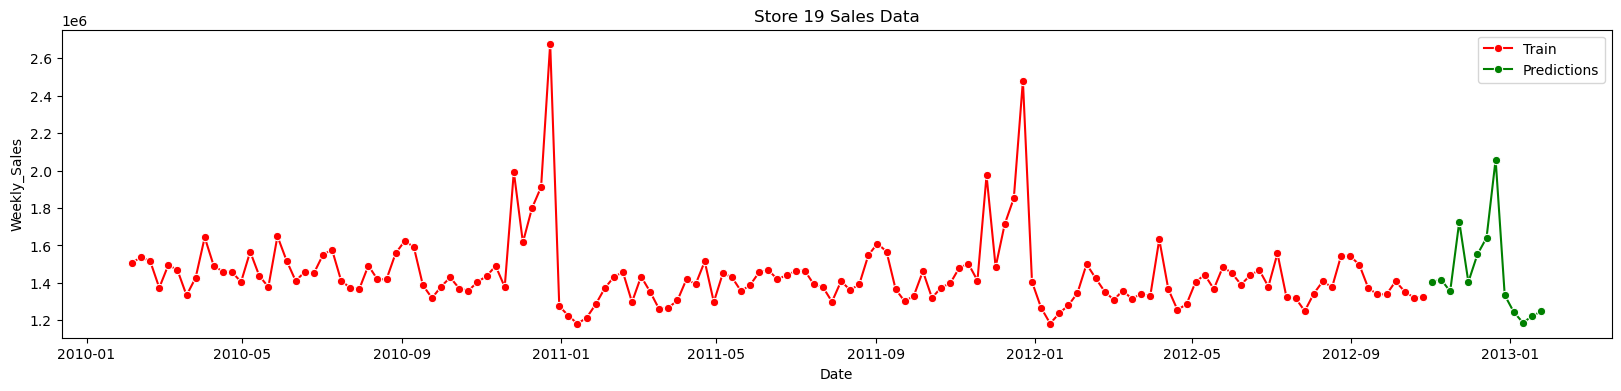

Store: 20


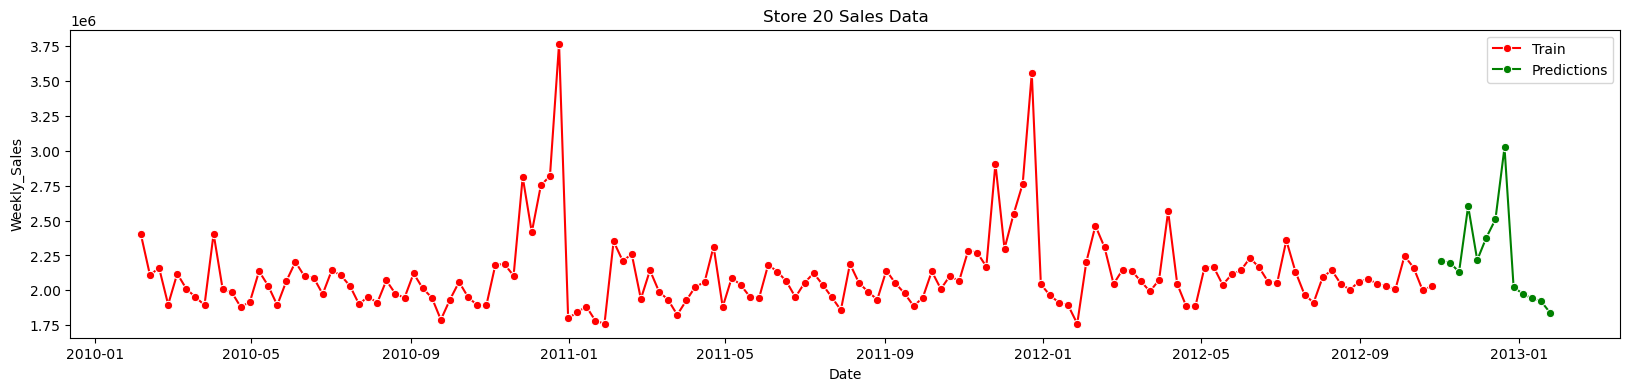

Store: 21


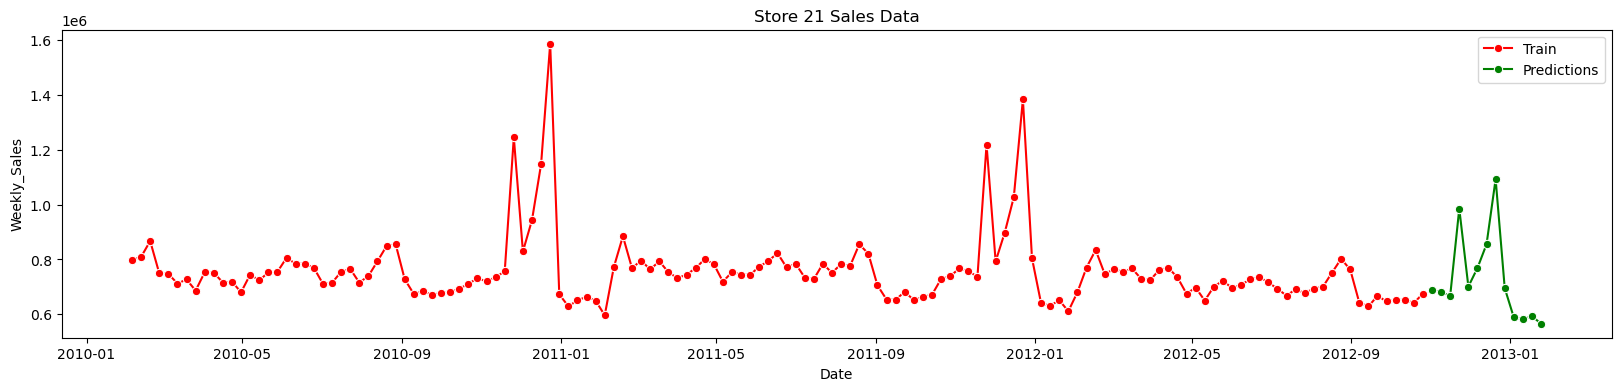

Store: 22


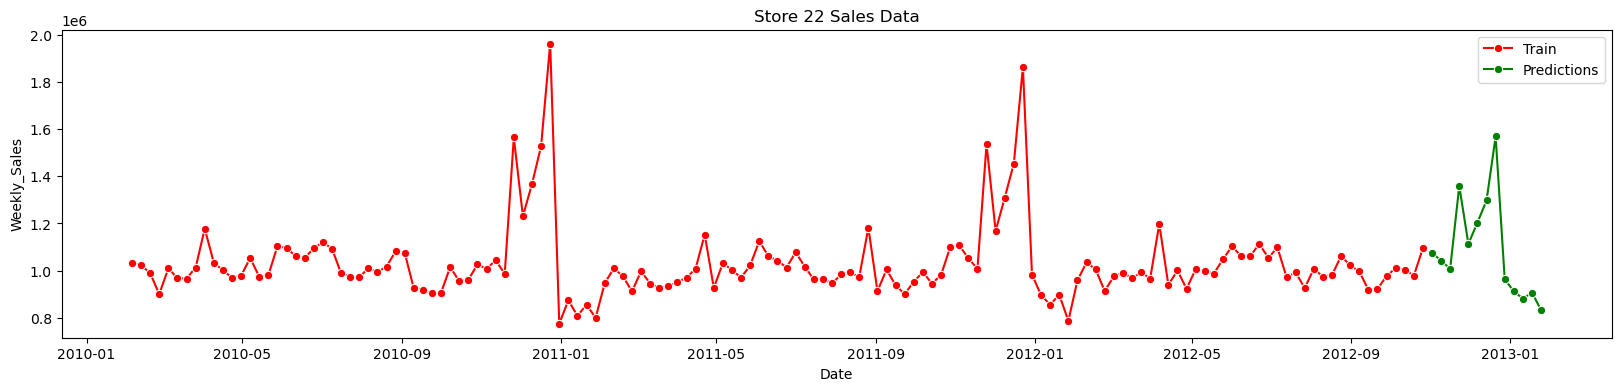

Store: 23


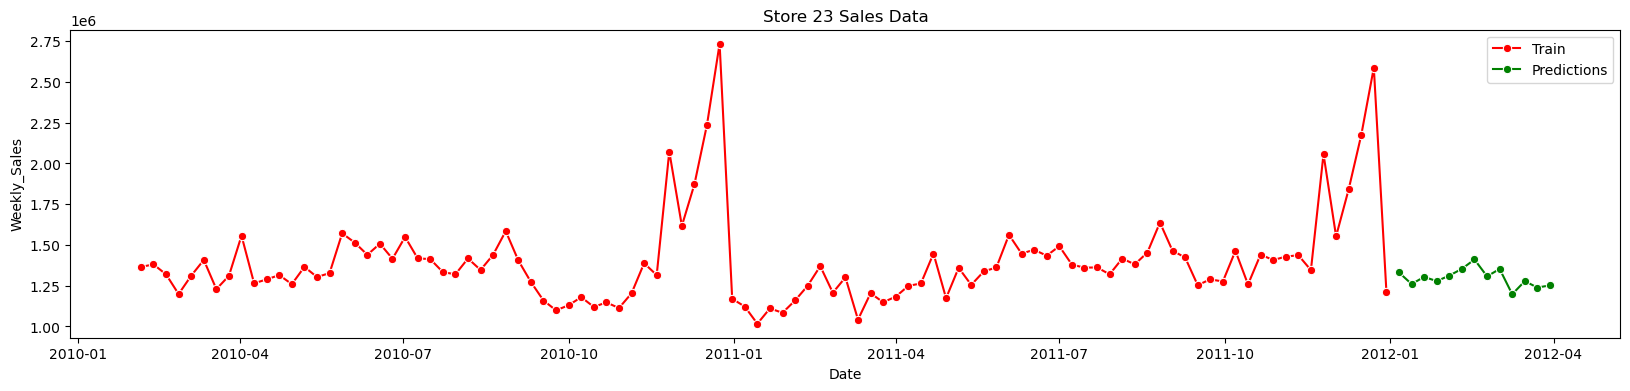

Store: 24


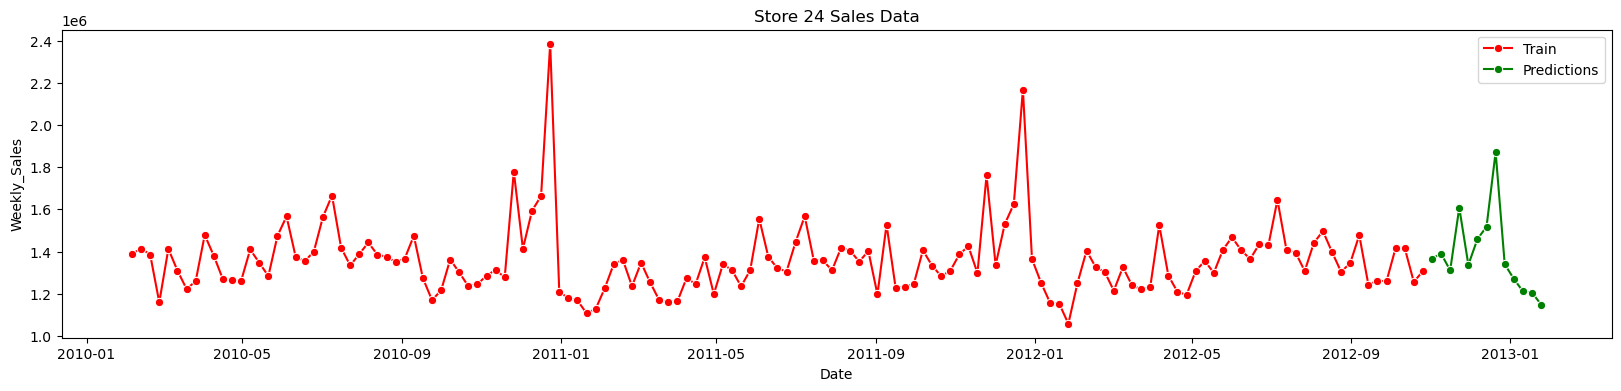

Store: 25


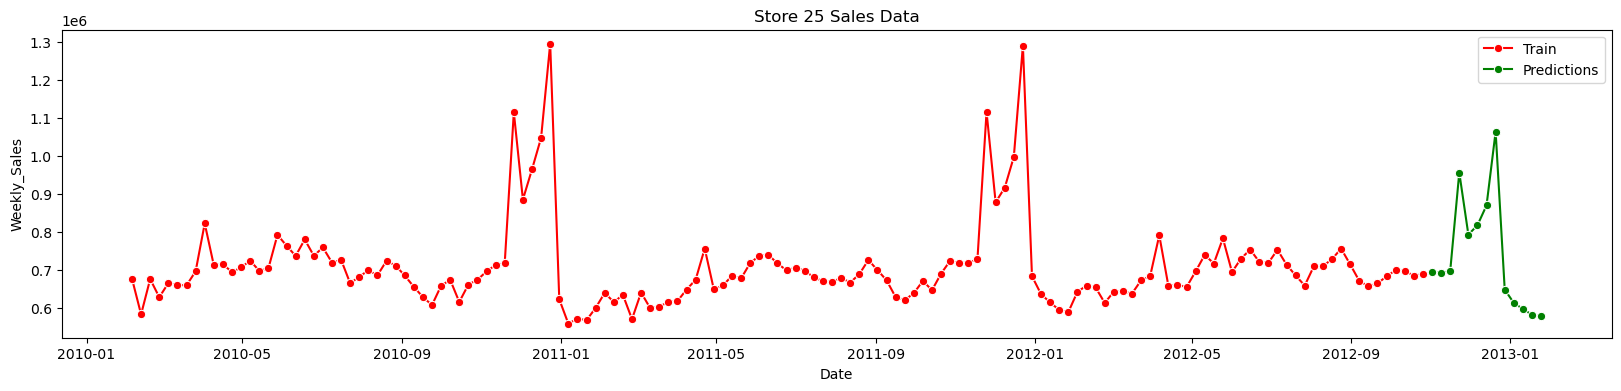

Store: 26


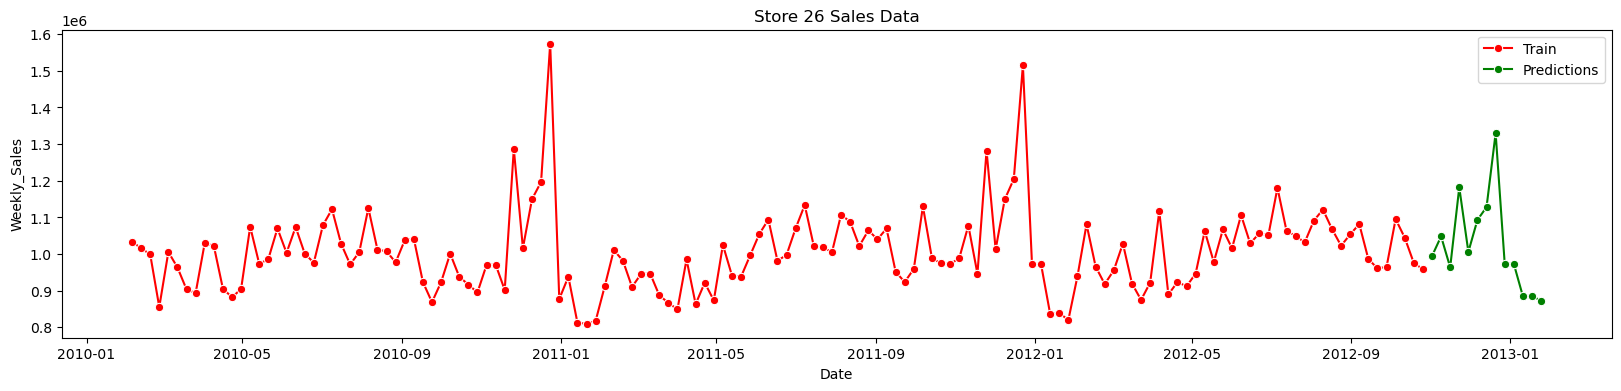

Store: 27


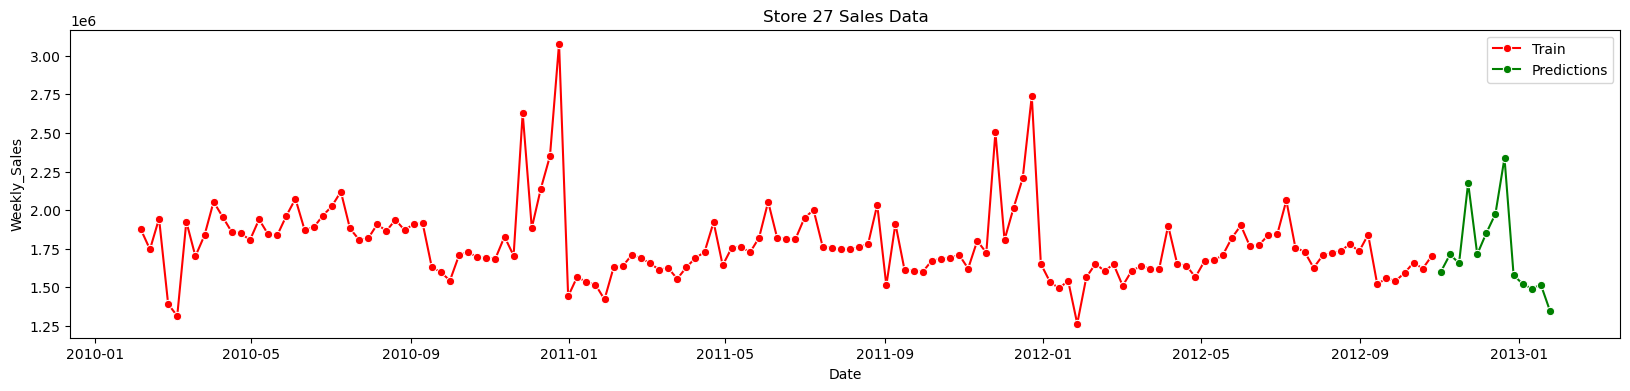

Store: 28


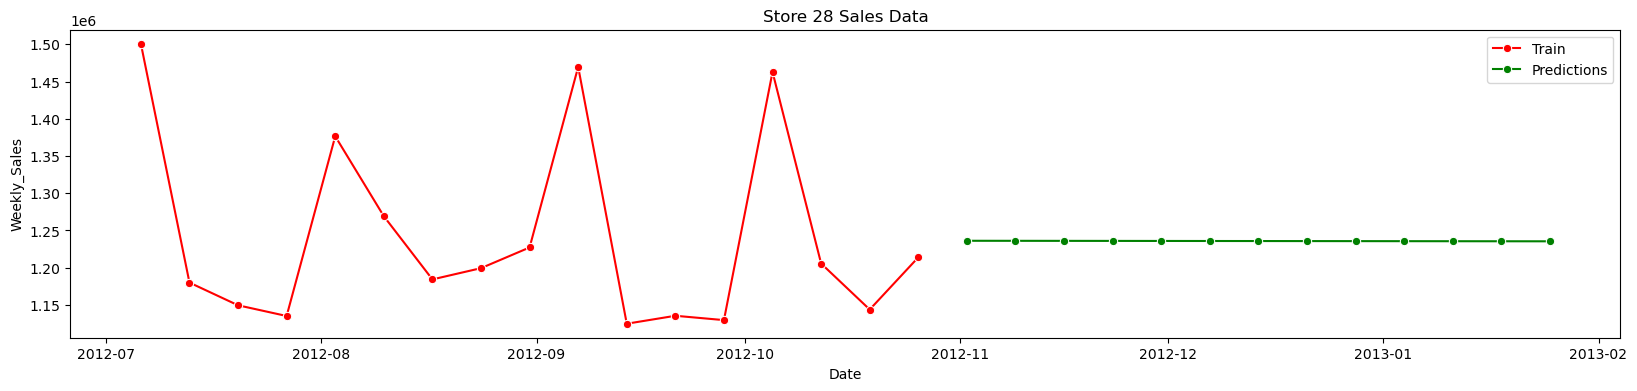

Store: 29


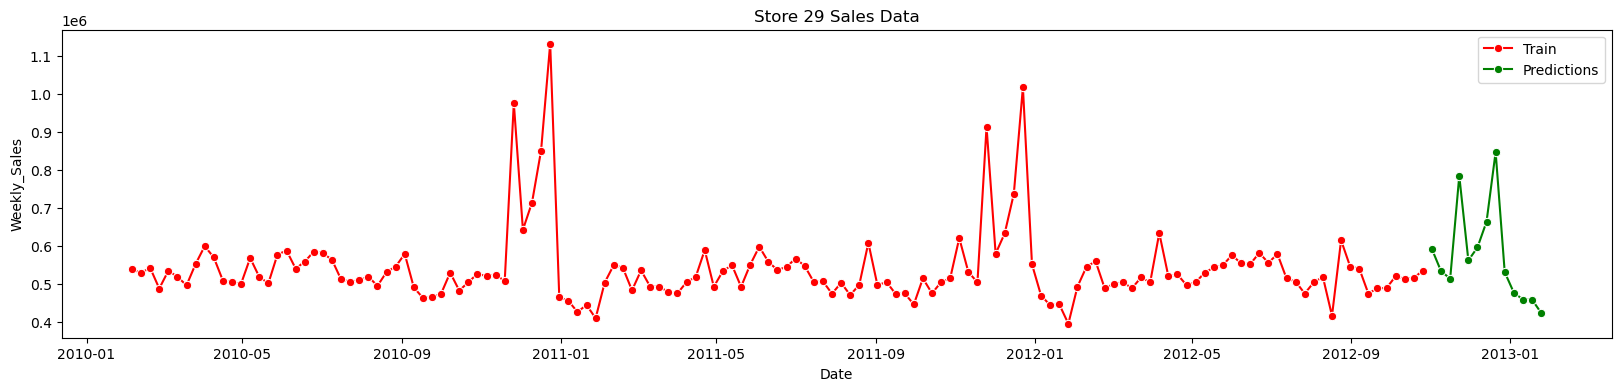

Store: 30


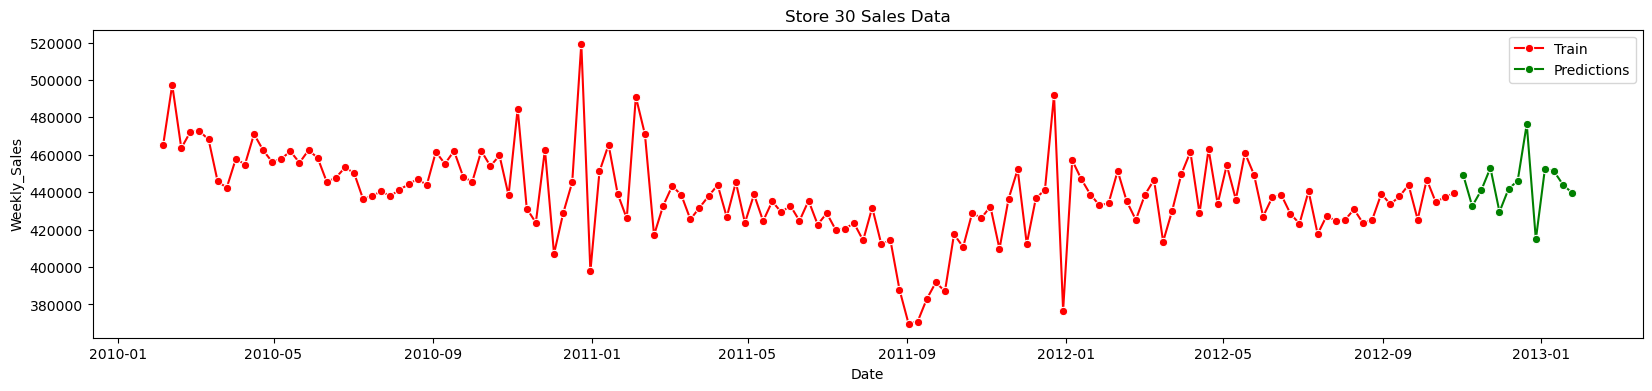

Store: 31


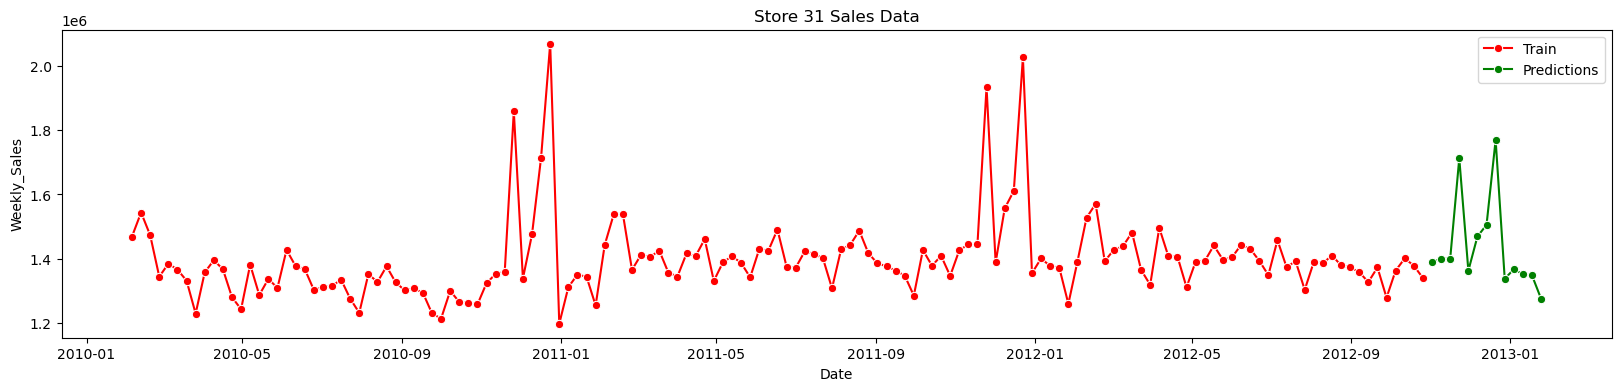

Store: 32


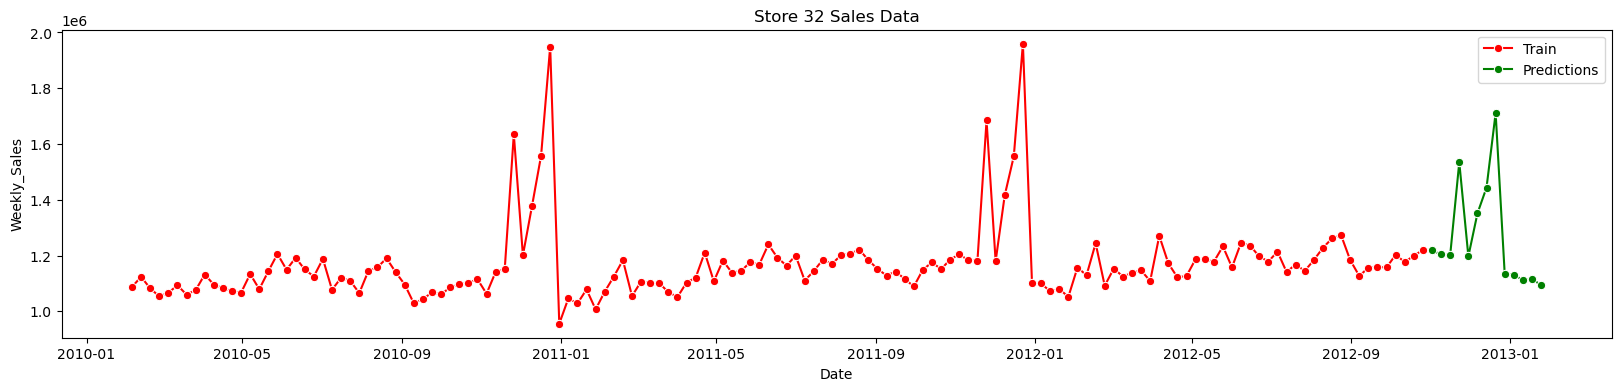

Store: 33


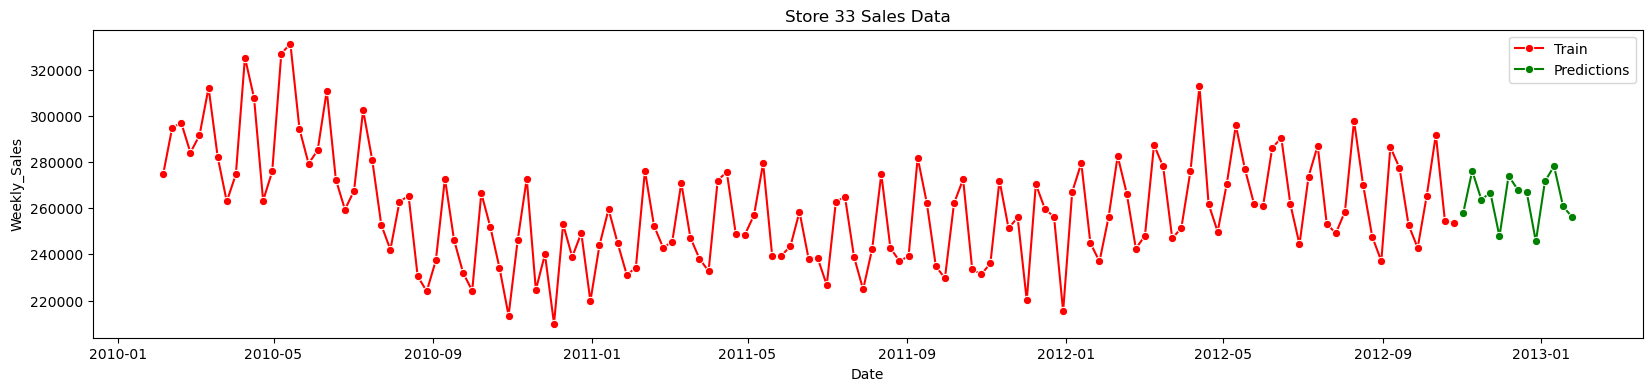

Store: 34


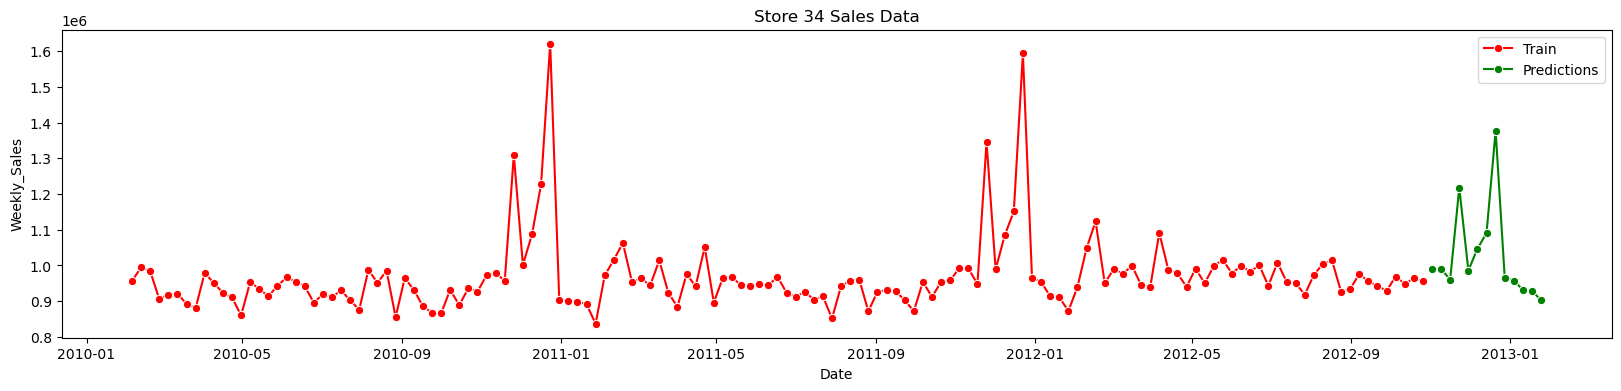

Store: 35


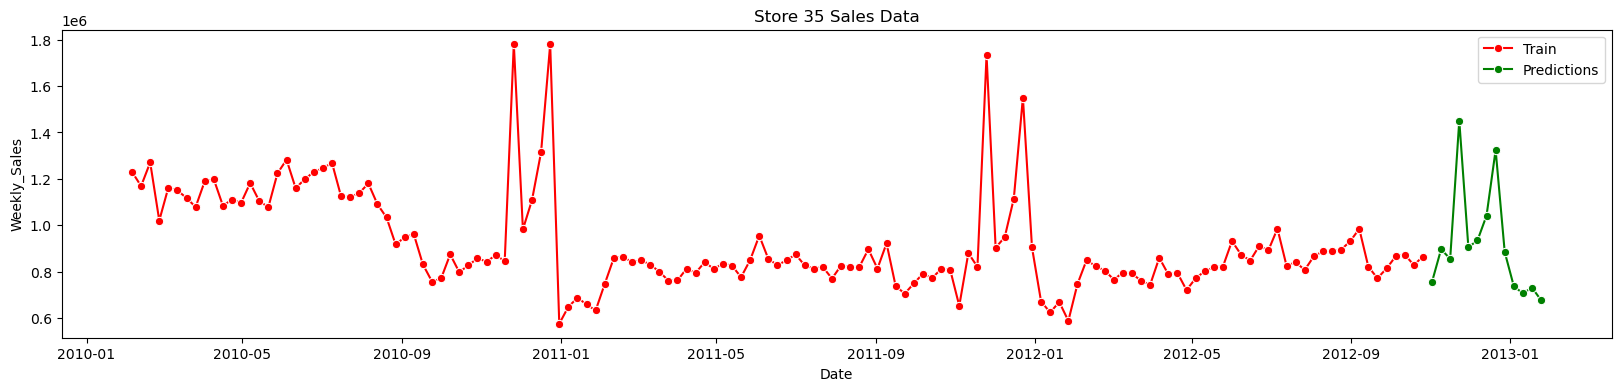

Store: 36


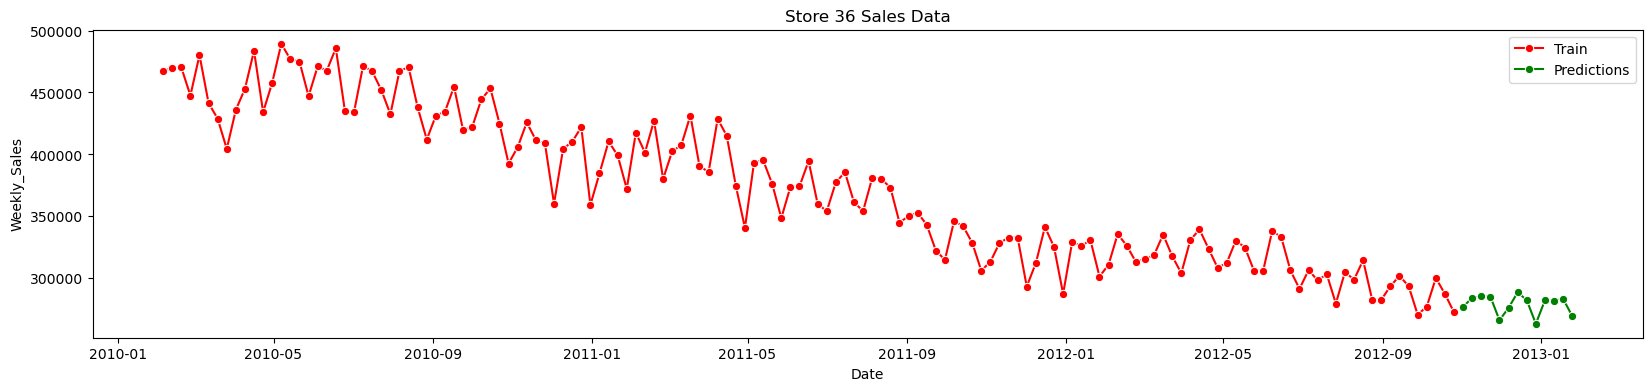

Store: 37


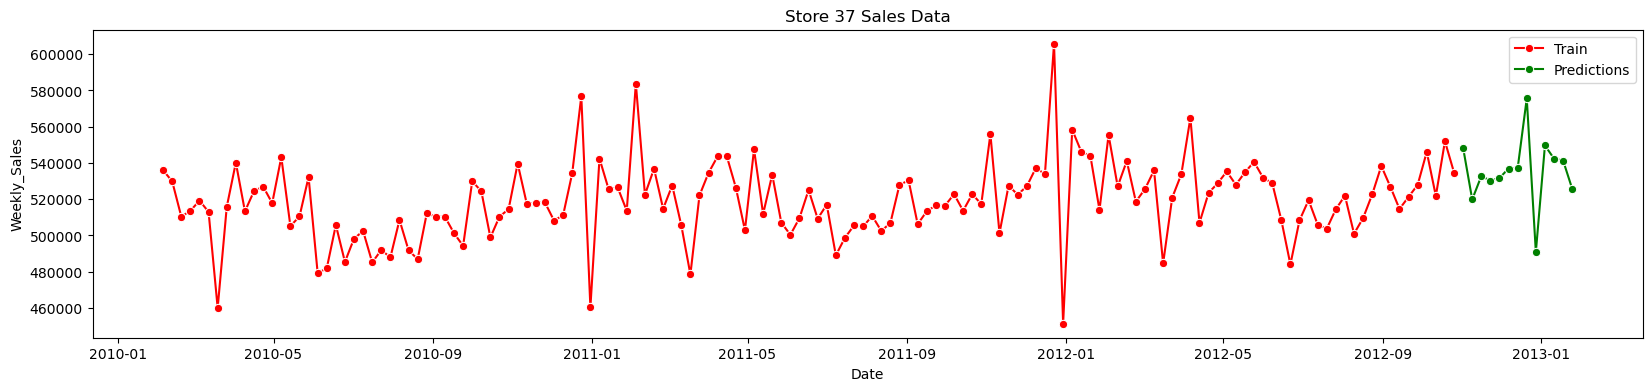

Store: 38


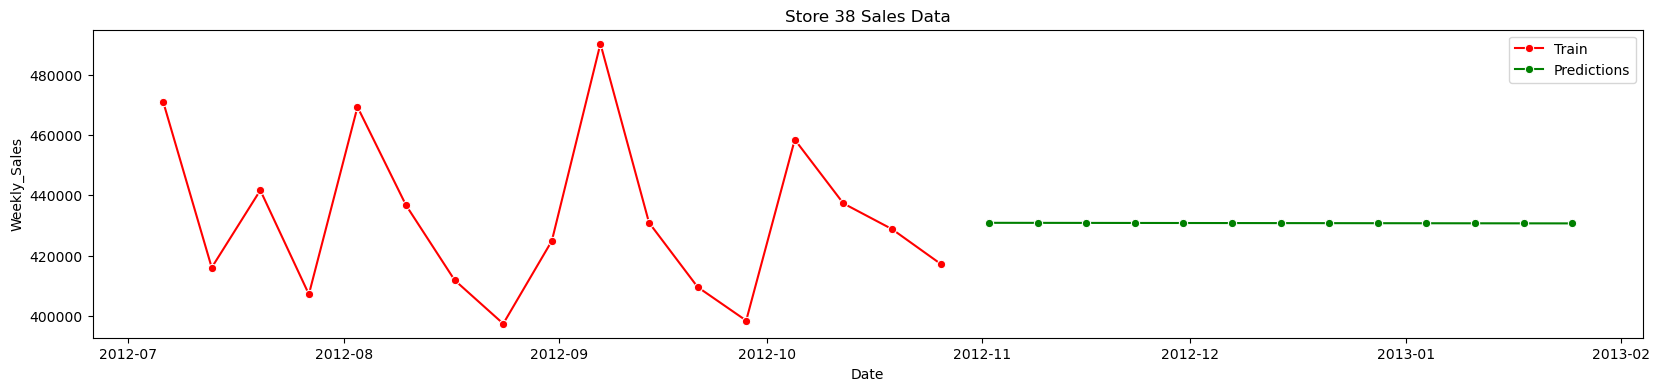

Store: 39


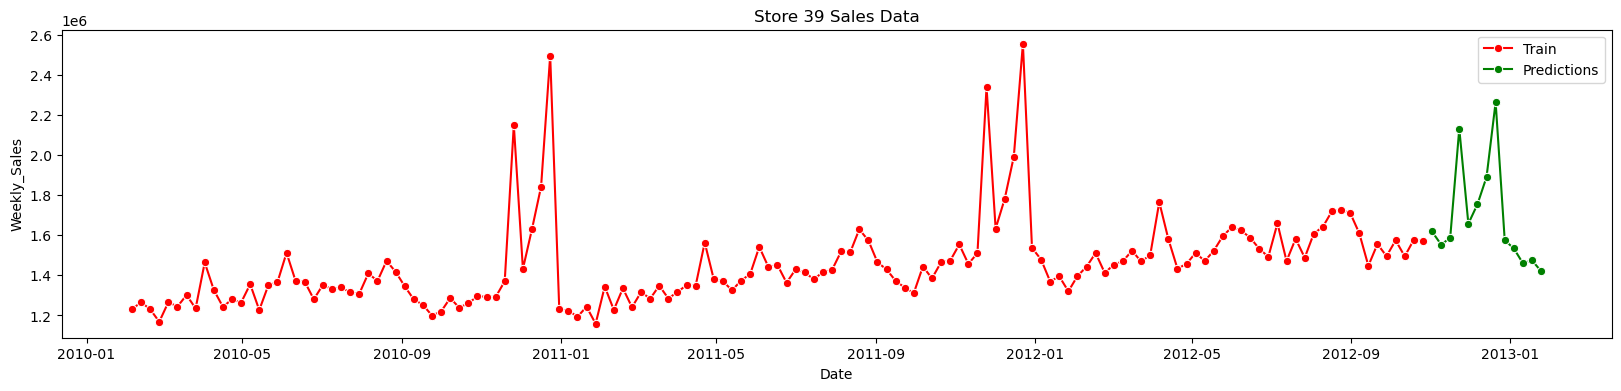

Store: 40


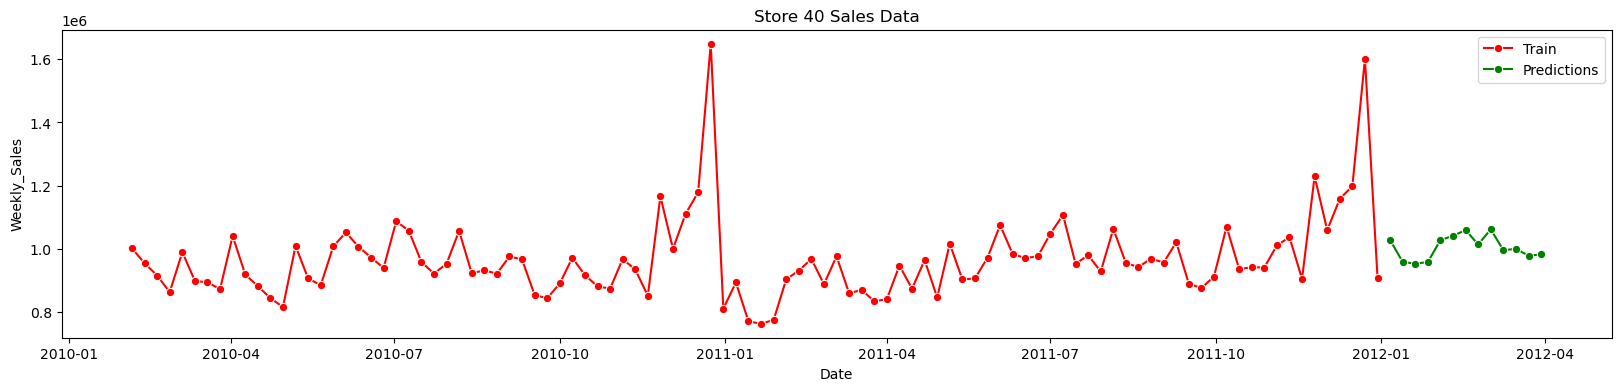

Store: 41


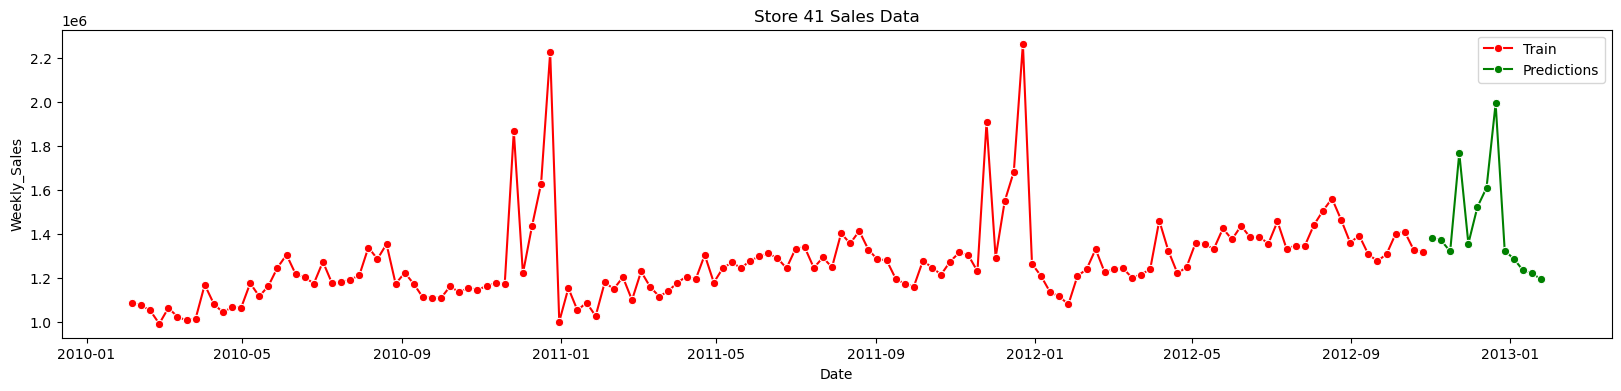

Store: 42


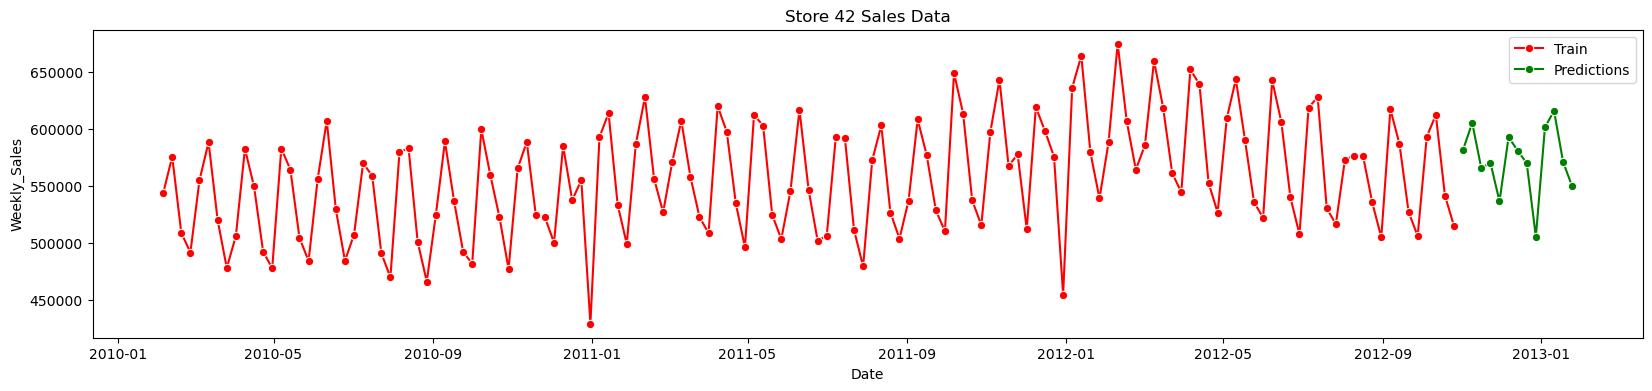

Store: 43


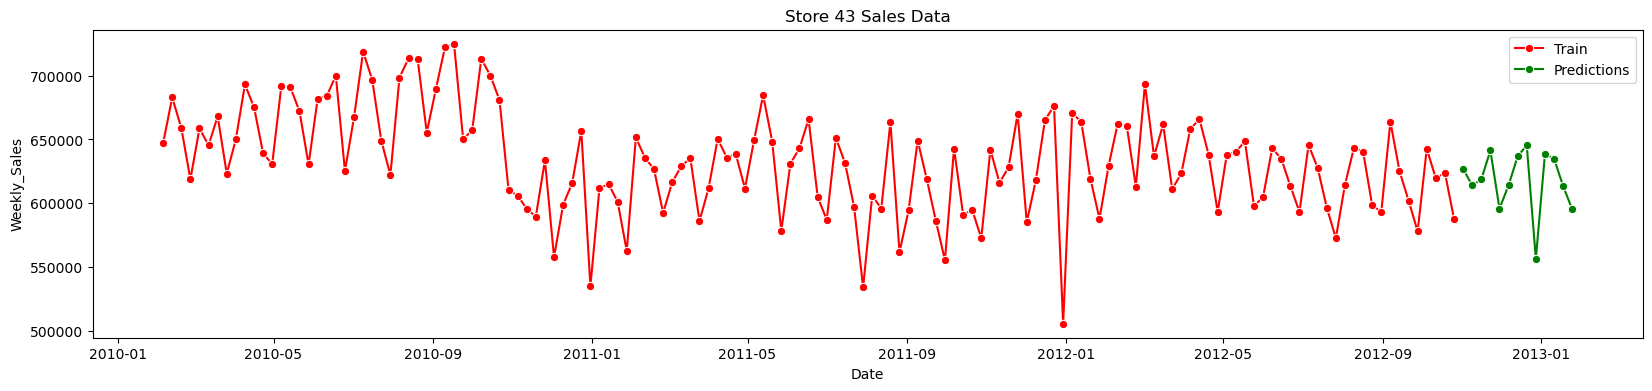

Store: 44


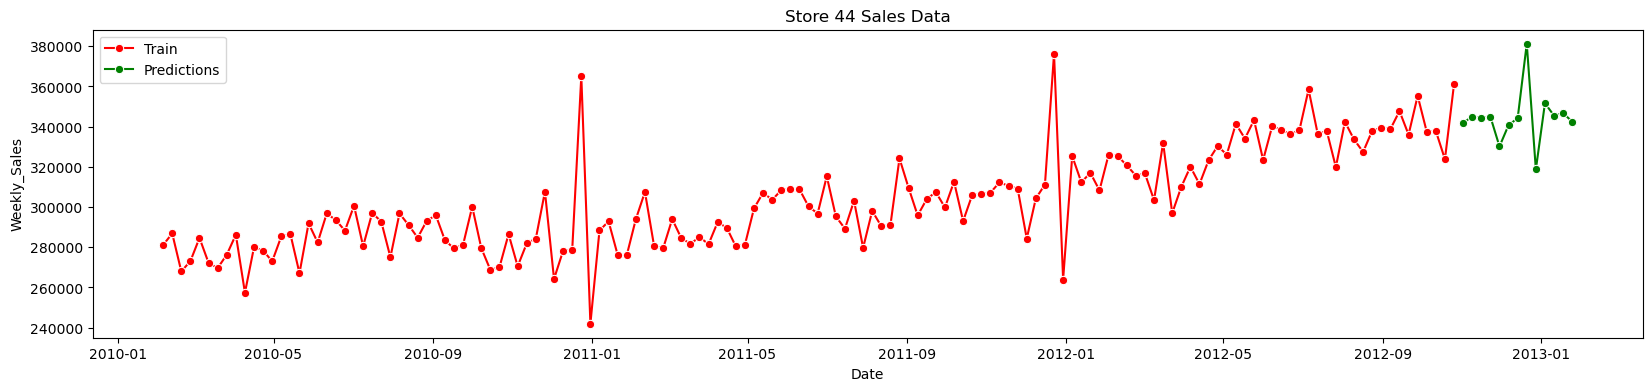

Store: 45


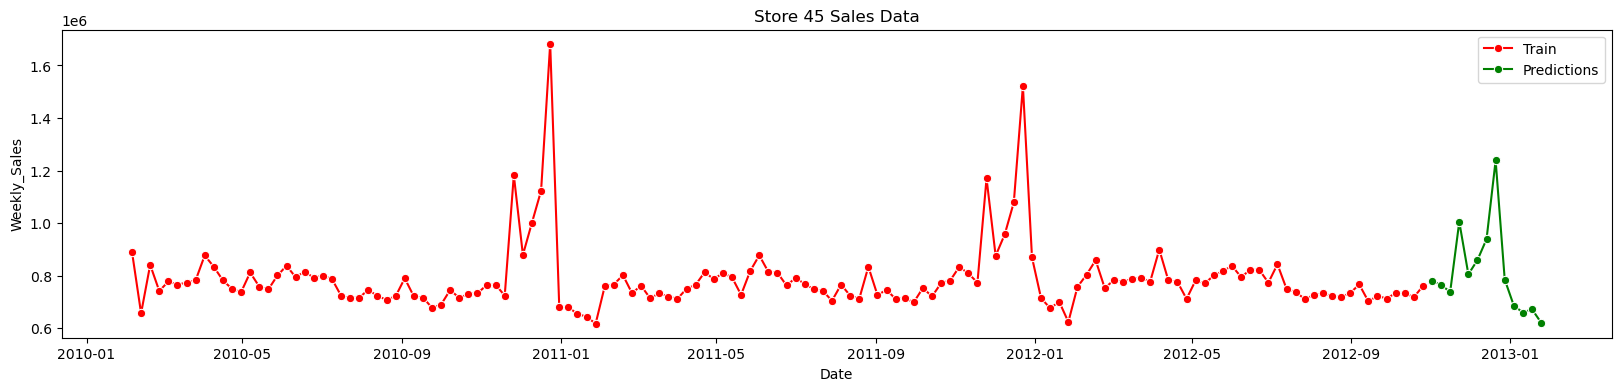

In [42]:
for store in df6['Store'].unique():
    print(f'Store: {store}')
    df_train = pd.DataFrame(df6[df6['Store']==store]['Weekly_Sales'])
    df_train = df_train.fillna(df_train.mean())

    train_len = df_train.size
    df_train = df_train.asfreq('W-Fri')
    sarima_model = SARIMAX(df_train, order = (1, 0, 1), seasonal_order = (1,0,1,52))
    sarima_model = sarima_model.fit()
    preds = sarima_model.predict(start=train_len, end=train_len+12)
    preds = pd.DataFrame(preds)
    
    #print(f'Past sales: \n{df_train}\n')
    #print(f'Next 12 weeks prediction: \n{preds}\n\n\n\n')

    plt.figure(figsize = (20, 4))
    sns.lineplot(data = df_train, x = 'Date', y = 'Weekly_Sales', marker = 'o', color = 'red', label = 'Train')
    sns.lineplot(data = preds, x = preds.index, y = 'predicted_mean', marker = 'o', color = 'green', label = 'Predictions')
    plt.title(f'Store {store} Sales Data')
    plt.show()